# 프로젝트 : Segmentation map으로 도로 이미지 만들기

[cityscapes.zip](https://aiffelstaticprd.blob.core.windows.net/media/documents/cityscapes.zip)


/home/aiffel-dj60/aiffel/cityscapes_pix2pix_dataset 에 저장

이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 레이블 정보 이미지를 입력으로 사용하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없습니다.    
아래 Tensroflow에서 제공하는 Pix2Pix 튜토리얼은 위 이미지와 비슷한 레이블 정보 이미지를 사용하기 때문에 좋은 참고 자료가 될 수 있을 것 같습니다.    

프로젝트 시작에 어려움이 있다면 아래 튜토리얼을 참고하시면서 이번 프로젝트를 수행해봅시다.    
(아래 튜토리얼은 Pix2Pix 구조를 Functional API를 이용해 구현하기 때문에 이번에 진행한 Subclassing 방법을 이용한 모델 구현과 비교하면서 구현 방법에 대해서도 공부해 보시길 추천드립니다)

- [Tensorflow Pix2Pix Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)

# 프로젝트 수행
프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.
(어떠한 방법을 사용했는지 적어주세요.)
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

# 데이터 준비

내용과 같이 1000개 이미지가 있음

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


## 데이터 시각화
학습용 데이터셋에서 임의로 6장을 선택하여 시각화합니다.

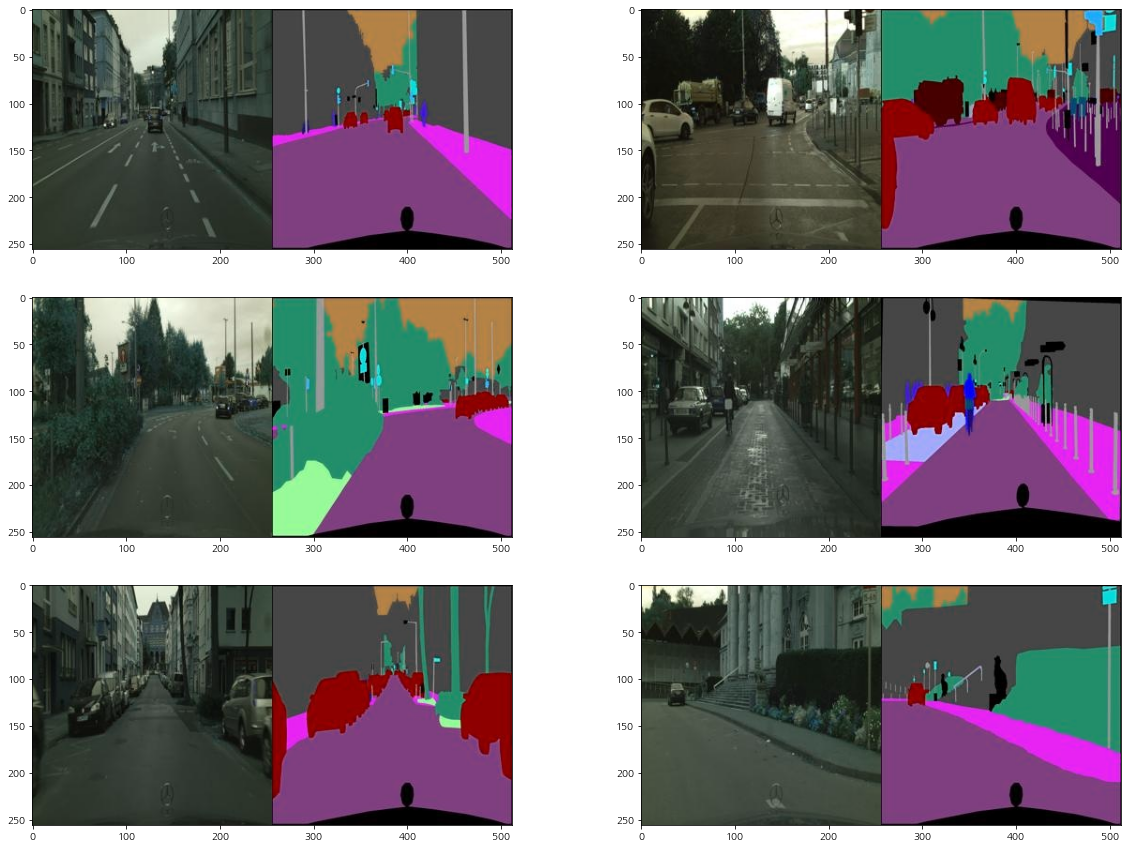

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

## 이미지 크기 확인하기
이미지를 하나 열어 아래와 같이 크기를 확인

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


## sketch이미지, colored이미지 분할 함수  
- load_img함수의 리턴값은 return 값이 normalize(sketch), normalize(colored)
 

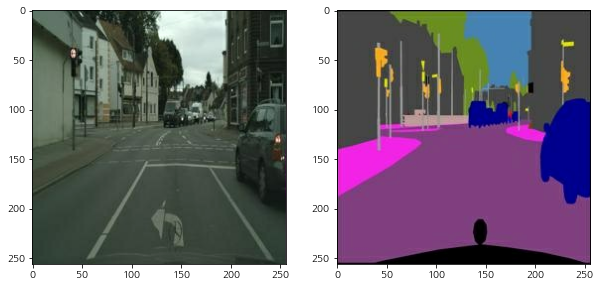

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

# return 값이 normalize(sketch), normalize(colored)
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## augmentation 방법을 적용

<strong>apply_augmentation 함수</strong>는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용한다.

1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)

2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)

3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)

4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)

5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


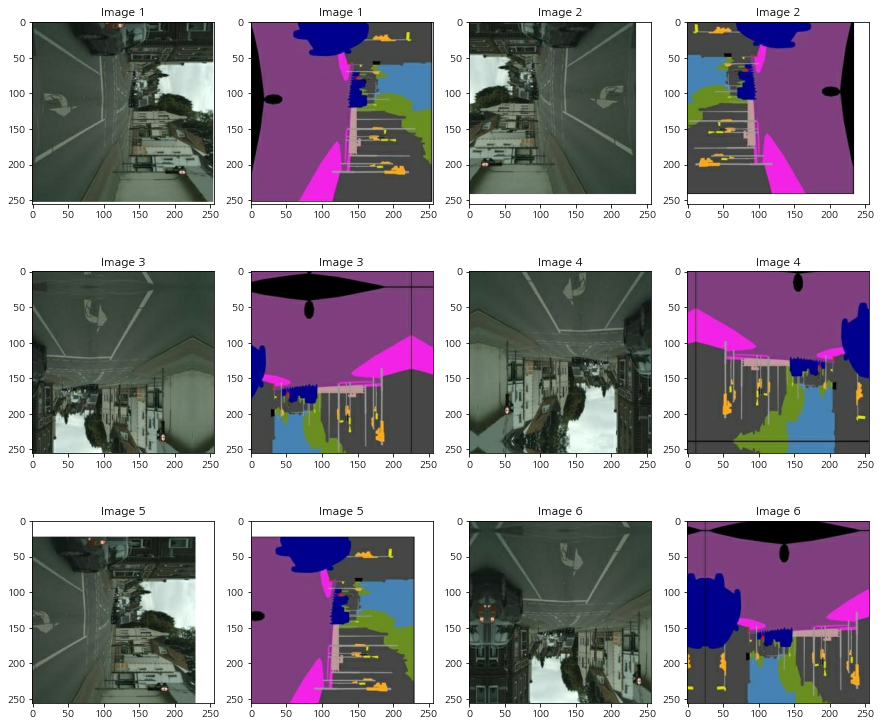

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해 보겠습니다.

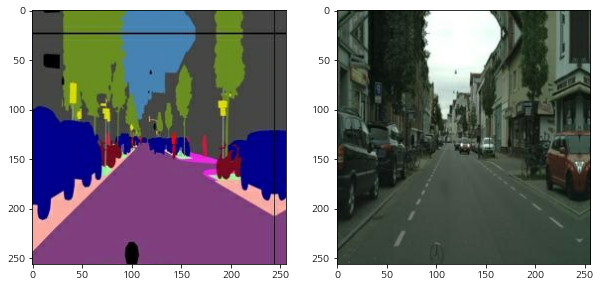

In [7]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return colored, sketch

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# Generator 구성하기
## Generator의 Encoder 부분을 구현하기    
먼저 위 논문에서 "C64", "C128" 등으로 쓰여진 것과 같이 "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만듬

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


\_init_() 메서드에서 n_filters, use_bn를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정 한다.    
이외 Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정했다.           
Encoder에 사용되는 기본 블록을 구성했으니 이 블록을 사용하면 아래와 같이 쉽게 Encoder를 구성하자.

In [9]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


위에서 구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 확인해보자.

In [10]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨을 확인 할 수 있습니다.

---

## Generator의 Decoder 부분을 구현하기

In [11]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")


✅


처음 세 개의 블록에서만 Dropout을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력한다.
(1,1,512) 크기의 데이터가 입력되었을 때, 어떤 크기가 출력되는지 확인해자

In [12]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

## f.keras.Model을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성하기

In [13]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


# Generator 재구성하기
- encoder 및 Decoder에 사용되는 기본적인 블록은 이전에 아래 코드와 같이 구현했었습니다.

In [14]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


### U-Net Generator를 정의
\_init_() 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고, call()에서 forward propagation 하게 한다. 이전 구현에는 없었던 skip connection이 call() 내부에서 어떻게 구현되었는지 잘 확인해보자

In [15]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


- init() 에서 정의된 encode_blocks 및 decode_blocks가 call() 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행한다.

- Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 리스트에 차례로 담음

- Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데, features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용된다.

### 완성된 U-Net 구조 Generator 내부의 각 출력

In [16]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

이전 Encoder-Decoder Generator 구조에서 학습해야 할 파라미터는 약 4000만 개 였는데, Skip connection을 추가한 U-Net Generator의 파라미터는 약 5500만 개로 늘어 났다.

# Discriminator 구성하기

## Discriminator에 사용할 기본적인 블록 만들기

In [17]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


\_init_()에서 기본설정을 하였다.    
필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad), BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능하다.

In [18]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


이러한 코드와 비슷한 설정으로 (width, height) 크기를 1씩 감소시킬 수 있습니다. 마지막 2개 블록은 출력의 크기가 1씩 감소하므로 이런 방식을 적용하면 되겠습니다.

Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30,30) 크기로 맞추느라 위와 같이 조금 복잡한 과정을 하였다. 여기까지 Discriminator에서 사용할  기본적인 블록을 만들었다.

## Discriminator 모델

In [19]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


\_init_() 내부에서 사용할 블록들을 정의했는데, 이전의 구현들처럼 (위 코드의 주석 처리된 부분과 같이) for loop로 간편하게 블록을 만들 수도 있지만, 쉽게 코드를 읽게끔 총 6개 블록을 각각 따로 만들었습니다. 첫 번째 블록은 단순한 연결(concat)을 수행하며, Discriminator의 최종 출력은 sigmoid 활성화를 사용했다.

## 각 블록의 출력 크기가 확인해보기

In [20]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

두 개의 (256,256,3) 크기 입력으로 최종 (30,30,1) 출력을 만들었다.

## 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화

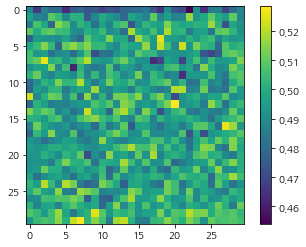

In [21]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

# 학습 및 테스트하기

## 손실 함수 사용하기(Generator 및 Discriminator의 손실 계산)
- 레이블 정보만 있는 입력에 대해 여러 손실함수를 사용해 실제 이미지를 만들어 낸 결과는, 일반적인 GAN의 손실함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성하였다. 


### Generator의 손실함수 
(아래 코드의 get_gene_loss)는 총 3개의 입력 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용합니다.    

L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산한다.

### Discriminator의 손실함수 
(위 코드의 get_disc_loss)는 2개의 입력이 있으며이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값이다

Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교한다.



In [22]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [23]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 아래와 같이 구현했다.

In [24]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [25]:
## EPOCHS = 100
EPOCHS = 200
## EPOCHS = 300
generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8362                     
L1_loss:0.3229                     
Discriminator_loss:1.3038

EPOCH[1] - STEP[20]                     
Generator_loss:0.9992                     
L1_loss:0.2744                     
Discriminator_loss:1.1681

EPOCH[1] - STEP[30]                     
Generator_loss:1.1061                     
L1_loss:0.1923                     
Discriminator_loss:1.4940

EPOCH[1] - STEP[40]                     
Generator_loss:0.8412                     
L1_loss:0.2264                     
Discriminator_loss:1.2640

EPOCH[1] - STEP[50]                     
Generator_loss:0.9258                     
L1_loss:0.1880                     
Discriminator_loss:1.2064

EPOCH[1] - STEP[60]                     
Generator_loss:1.0852                     
L1_loss:0.1761                     
Discriminator_loss:1.1819

EPOCH[1] - STEP[70]                     
Generator_loss:1.1594                     
L1_loss:0.1677                    

EPOCH[3] - STEP[70]                     
Generator_loss:2.1520                     
L1_loss:0.1536                     
Discriminator_loss:0.9592

EPOCH[3] - STEP[80]                     
Generator_loss:2.5170                     
L1_loss:0.1669                     
Discriminator_loss:0.7806

EPOCH[3] - STEP[90]                     
Generator_loss:2.8451                     
L1_loss:0.1670                     
Discriminator_loss:0.3333

EPOCH[3] - STEP[100]                     
Generator_loss:3.5719                     
L1_loss:0.2049                     
Discriminator_loss:0.3537

EPOCH[3] - STEP[110]                     
Generator_loss:2.7251                     
L1_loss:0.1963                     
Discriminator_loss:0.5125

EPOCH[3] - STEP[120]                     
Generator_loss:2.3535                     
L1_loss:0.1919                     
Discriminator_loss:0.6111

EPOCH[3] - STEP[130]                     
Generator_loss:1.2253                     
L1_loss:0.2085                

EPOCH[5] - STEP[130]                     
Generator_loss:1.2189                     
L1_loss:0.1541                     
Discriminator_loss:0.7072

EPOCH[5] - STEP[140]                     
Generator_loss:1.3025                     
L1_loss:0.2128                     
Discriminator_loss:0.8051

EPOCH[5] - STEP[150]                     
Generator_loss:0.4235                     
L1_loss:0.2040                     
Discriminator_loss:1.3839

EPOCH[5] - STEP[160]                     
Generator_loss:1.1208                     
L1_loss:0.1552                     
Discriminator_loss:1.4923

EPOCH[5] - STEP[170]                     
Generator_loss:1.7430                     
L1_loss:0.1979                     
Discriminator_loss:0.5427

EPOCH[5] - STEP[180]                     
Generator_loss:0.6738                     
L1_loss:0.1967                     
Discriminator_loss:1.2143

EPOCH[5] - STEP[190]                     
Generator_loss:2.3935                     
L1_loss:0.2007             

EPOCH[7] - STEP[190]                     
Generator_loss:2.7944                     
L1_loss:0.1606                     
Discriminator_loss:2.0427

EPOCH[7] - STEP[200]                     
Generator_loss:0.8230                     
L1_loss:0.1583                     
Discriminator_loss:0.7041

EPOCH[7] - STEP[210]                     
Generator_loss:0.9513                     
L1_loss:0.1574                     
Discriminator_loss:0.9015

EPOCH[7] - STEP[220]                     
Generator_loss:0.6075                     
L1_loss:0.2008                     
Discriminator_loss:1.1306

EPOCH[7] - STEP[230]                     
Generator_loss:0.2491                     
L1_loss:0.2057                     
Discriminator_loss:1.7093

EPOCH[7] - STEP[240]                     
Generator_loss:1.6312                     
L1_loss:0.1681                     
Discriminator_loss:0.3892

EPOCH[7] - STEP[250]                     
Generator_loss:1.0461                     
L1_loss:0.2025             

EPOCH[9] - STEP[250]                     
Generator_loss:1.7076                     
L1_loss:0.2019                     
Discriminator_loss:1.0153

EPOCH[10] - STEP[10]                     
Generator_loss:1.4191                     
L1_loss:0.1803                     
Discriminator_loss:0.6099

EPOCH[10] - STEP[20]                     
Generator_loss:1.9252                     
L1_loss:0.1967                     
Discriminator_loss:0.6049

EPOCH[10] - STEP[30]                     
Generator_loss:1.0668                     
L1_loss:0.1762                     
Discriminator_loss:1.5263

EPOCH[10] - STEP[40]                     
Generator_loss:1.1141                     
L1_loss:0.2133                     
Discriminator_loss:0.4573

EPOCH[10] - STEP[50]                     
Generator_loss:2.1774                     
L1_loss:0.2086                     
Discriminator_loss:0.6244

EPOCH[10] - STEP[60]                     
Generator_loss:1.2144                     
L1_loss:0.1538             

EPOCH[12] - STEP[60]                     
Generator_loss:1.5394                     
L1_loss:0.1703                     
Discriminator_loss:0.4011

EPOCH[12] - STEP[70]                     
Generator_loss:2.3577                     
L1_loss:0.1521                     
Discriminator_loss:2.4087

EPOCH[12] - STEP[80]                     
Generator_loss:2.2481                     
L1_loss:0.1527                     
Discriminator_loss:1.1174

EPOCH[12] - STEP[90]                     
Generator_loss:1.7289                     
L1_loss:0.1886                     
Discriminator_loss:0.4707

EPOCH[12] - STEP[100]                     
Generator_loss:1.5918                     
L1_loss:0.1912                     
Discriminator_loss:0.4418

EPOCH[12] - STEP[110]                     
Generator_loss:1.9340                     
L1_loss:0.1820                     
Discriminator_loss:0.6621

EPOCH[12] - STEP[120]                     
Generator_loss:1.2771                     
L1_loss:0.1979          

EPOCH[14] - STEP[120]                     
Generator_loss:1.5301                     
L1_loss:0.1858                     
Discriminator_loss:0.6651

EPOCH[14] - STEP[130]                     
Generator_loss:1.1391                     
L1_loss:0.1699                     
Discriminator_loss:1.2103

EPOCH[14] - STEP[140]                     
Generator_loss:1.1817                     
L1_loss:0.1681                     
Discriminator_loss:0.9064

EPOCH[14] - STEP[150]                     
Generator_loss:1.0783                     
L1_loss:0.1740                     
Discriminator_loss:0.7256

EPOCH[14] - STEP[160]                     
Generator_loss:0.4344                     
L1_loss:0.1760                     
Discriminator_loss:1.6928

EPOCH[14] - STEP[170]                     
Generator_loss:0.3684                     
L1_loss:0.2241                     
Discriminator_loss:1.3538

EPOCH[14] - STEP[180]                     
Generator_loss:1.3882                     
L1_loss:0.2016      

EPOCH[16] - STEP[180]                     
Generator_loss:1.9387                     
L1_loss:0.1761                     
Discriminator_loss:0.3422

EPOCH[16] - STEP[190]                     
Generator_loss:1.1646                     
L1_loss:0.1654                     
Discriminator_loss:0.5354

EPOCH[16] - STEP[200]                     
Generator_loss:1.5163                     
L1_loss:0.1578                     
Discriminator_loss:0.8206

EPOCH[16] - STEP[210]                     
Generator_loss:2.8673                     
L1_loss:0.1735                     
Discriminator_loss:1.3304

EPOCH[16] - STEP[220]                     
Generator_loss:1.9642                     
L1_loss:0.1566                     
Discriminator_loss:1.9952

EPOCH[16] - STEP[230]                     
Generator_loss:2.5081                     
L1_loss:0.2030                     
Discriminator_loss:0.1882

EPOCH[16] - STEP[240]                     
Generator_loss:1.7837                     
L1_loss:0.1782      

EPOCH[18] - STEP[240]                     
Generator_loss:1.1147                     
L1_loss:0.1690                     
Discriminator_loss:2.7731

EPOCH[18] - STEP[250]                     
Generator_loss:2.0072                     
L1_loss:0.1970                     
Discriminator_loss:0.7229

EPOCH[19] - STEP[10]                     
Generator_loss:1.4604                     
L1_loss:0.2066                     
Discriminator_loss:0.3319

EPOCH[19] - STEP[20]                     
Generator_loss:0.5717                     
L1_loss:0.1940                     
Discriminator_loss:0.9837

EPOCH[19] - STEP[30]                     
Generator_loss:1.3640                     
L1_loss:0.1550                     
Discriminator_loss:0.9133

EPOCH[19] - STEP[40]                     
Generator_loss:2.0040                     
L1_loss:0.1537                     
Discriminator_loss:1.8957

EPOCH[19] - STEP[50]                     
Generator_loss:1.6306                     
L1_loss:0.1788           

EPOCH[21] - STEP[50]                     
Generator_loss:0.7567                     
L1_loss:0.1889                     
Discriminator_loss:0.9470

EPOCH[21] - STEP[60]                     
Generator_loss:0.8495                     
L1_loss:0.1683                     
Discriminator_loss:1.3178

EPOCH[21] - STEP[70]                     
Generator_loss:0.3707                     
L1_loss:0.1656                     
Discriminator_loss:1.6305

EPOCH[21] - STEP[80]                     
Generator_loss:1.5059                     
L1_loss:0.1799                     
Discriminator_loss:0.4490

EPOCH[21] - STEP[90]                     
Generator_loss:2.2887                     
L1_loss:0.1518                     
Discriminator_loss:0.5858

EPOCH[21] - STEP[100]                     
Generator_loss:2.3684                     
L1_loss:0.1848                     
Discriminator_loss:0.5837

EPOCH[21] - STEP[110]                     
Generator_loss:1.4885                     
L1_loss:0.2005           

EPOCH[23] - STEP[110]                     
Generator_loss:1.1082                     
L1_loss:0.1594                     
Discriminator_loss:1.7157

EPOCH[23] - STEP[120]                     
Generator_loss:1.0064                     
L1_loss:0.1641                     
Discriminator_loss:1.0102

EPOCH[23] - STEP[130]                     
Generator_loss:1.8909                     
L1_loss:0.1645                     
Discriminator_loss:1.4765

EPOCH[23] - STEP[140]                     
Generator_loss:1.5616                     
L1_loss:0.1503                     
Discriminator_loss:1.4566

EPOCH[23] - STEP[150]                     
Generator_loss:2.0409                     
L1_loss:0.2056                     
Discriminator_loss:0.2259

EPOCH[23] - STEP[160]                     
Generator_loss:1.3247                     
L1_loss:0.1825                     
Discriminator_loss:0.7275

EPOCH[23] - STEP[170]                     
Generator_loss:0.3519                     
L1_loss:0.1770      

EPOCH[25] - STEP[170]                     
Generator_loss:1.3751                     
L1_loss:0.1653                     
Discriminator_loss:0.7401

EPOCH[25] - STEP[180]                     
Generator_loss:0.8239                     
L1_loss:0.1976                     
Discriminator_loss:0.8114

EPOCH[25] - STEP[190]                     
Generator_loss:1.1976                     
L1_loss:0.1576                     
Discriminator_loss:1.5538

EPOCH[25] - STEP[200]                     
Generator_loss:1.6962                     
L1_loss:0.1925                     
Discriminator_loss:0.4451

EPOCH[25] - STEP[210]                     
Generator_loss:0.9039                     
L1_loss:0.1760                     
Discriminator_loss:0.7296

EPOCH[25] - STEP[220]                     
Generator_loss:1.5796                     
L1_loss:0.1612                     
Discriminator_loss:1.3594

EPOCH[25] - STEP[230]                     
Generator_loss:0.6867                     
L1_loss:0.1615      

EPOCH[27] - STEP[230]                     
Generator_loss:2.0888                     
L1_loss:0.1789                     
Discriminator_loss:0.6064

EPOCH[27] - STEP[240]                     
Generator_loss:2.4497                     
L1_loss:0.2183                     
Discriminator_loss:0.5429

EPOCH[27] - STEP[250]                     
Generator_loss:1.6127                     
L1_loss:0.1826                     
Discriminator_loss:0.8901

EPOCH[28] - STEP[10]                     
Generator_loss:0.8974                     
L1_loss:0.1873                     
Discriminator_loss:0.6428

EPOCH[28] - STEP[20]                     
Generator_loss:0.7084                     
L1_loss:0.1740                     
Discriminator_loss:0.9193

EPOCH[28] - STEP[30]                     
Generator_loss:1.0977                     
L1_loss:0.1819                     
Discriminator_loss:0.4921

EPOCH[28] - STEP[40]                     
Generator_loss:0.7313                     
L1_loss:0.2240          

EPOCH[30] - STEP[40]                     
Generator_loss:1.8304                     
L1_loss:0.1597                     
Discriminator_loss:0.4517

EPOCH[30] - STEP[50]                     
Generator_loss:0.9364                     
L1_loss:0.1938                     
Discriminator_loss:0.6493

EPOCH[30] - STEP[60]                     
Generator_loss:2.6049                     
L1_loss:0.1601                     
Discriminator_loss:1.5769

EPOCH[30] - STEP[70]                     
Generator_loss:1.2452                     
L1_loss:0.2170                     
Discriminator_loss:0.3931

EPOCH[30] - STEP[80]                     
Generator_loss:0.8735                     
L1_loss:0.1479                     
Discriminator_loss:1.2042

EPOCH[30] - STEP[90]                     
Generator_loss:2.9017                     
L1_loss:0.1782                     
Discriminator_loss:0.6078

EPOCH[30] - STEP[100]                     
Generator_loss:2.8144                     
L1_loss:0.1556            

EPOCH[32] - STEP[100]                     
Generator_loss:1.1394                     
L1_loss:0.1848                     
Discriminator_loss:0.8477

EPOCH[32] - STEP[110]                     
Generator_loss:1.7942                     
L1_loss:0.1560                     
Discriminator_loss:1.5187

EPOCH[32] - STEP[120]                     
Generator_loss:1.1292                     
L1_loss:0.2015                     
Discriminator_loss:0.4785

EPOCH[32] - STEP[130]                     
Generator_loss:1.4076                     
L1_loss:0.1763                     
Discriminator_loss:0.8443

EPOCH[32] - STEP[140]                     
Generator_loss:2.2156                     
L1_loss:0.1449                     
Discriminator_loss:0.8227

EPOCH[32] - STEP[150]                     
Generator_loss:0.6533                     
L1_loss:0.2290                     
Discriminator_loss:0.8142

EPOCH[32] - STEP[160]                     
Generator_loss:2.3572                     
L1_loss:0.1745      

EPOCH[34] - STEP[160]                     
Generator_loss:0.6822                     
L1_loss:0.1807                     
Discriminator_loss:0.8859

EPOCH[34] - STEP[170]                     
Generator_loss:0.5898                     
L1_loss:0.1636                     
Discriminator_loss:1.6854

EPOCH[34] - STEP[180]                     
Generator_loss:1.5027                     
L1_loss:0.1765                     
Discriminator_loss:0.6984

EPOCH[34] - STEP[190]                     
Generator_loss:1.3845                     
L1_loss:0.1761                     
Discriminator_loss:0.4224

EPOCH[34] - STEP[200]                     
Generator_loss:0.8565                     
L1_loss:0.1545                     
Discriminator_loss:1.3684

EPOCH[34] - STEP[210]                     
Generator_loss:0.4190                     
L1_loss:0.1876                     
Discriminator_loss:1.2269

EPOCH[34] - STEP[220]                     
Generator_loss:0.4200                     
L1_loss:0.2077      

EPOCH[36] - STEP[220]                     
Generator_loss:1.5947                     
L1_loss:0.2077                     
Discriminator_loss:0.3111

EPOCH[36] - STEP[230]                     
Generator_loss:0.8086                     
L1_loss:0.1652                     
Discriminator_loss:1.8656

EPOCH[36] - STEP[240]                     
Generator_loss:1.4581                     
L1_loss:0.1648                     
Discriminator_loss:0.3313

EPOCH[36] - STEP[250]                     
Generator_loss:1.2541                     
L1_loss:0.1568                     
Discriminator_loss:1.8354

EPOCH[37] - STEP[10]                     
Generator_loss:1.6067                     
L1_loss:0.1863                     
Discriminator_loss:0.6305

EPOCH[37] - STEP[20]                     
Generator_loss:1.2785                     
L1_loss:0.1617                     
Discriminator_loss:1.2243

EPOCH[37] - STEP[30]                     
Generator_loss:2.1299                     
L1_loss:0.1719         

EPOCH[39] - STEP[30]                     
Generator_loss:0.3419                     
L1_loss:0.1810                     
Discriminator_loss:1.5400

EPOCH[39] - STEP[40]                     
Generator_loss:1.0374                     
L1_loss:0.1457                     
Discriminator_loss:1.2186

EPOCH[39] - STEP[50]                     
Generator_loss:1.6426                     
L1_loss:0.1710                     
Discriminator_loss:0.7686

EPOCH[39] - STEP[60]                     
Generator_loss:2.0033                     
L1_loss:0.2135                     
Discriminator_loss:0.2253

EPOCH[39] - STEP[70]                     
Generator_loss:1.8686                     
L1_loss:0.1639                     
Discriminator_loss:0.6964

EPOCH[39] - STEP[80]                     
Generator_loss:2.3661                     
L1_loss:0.2140                     
Discriminator_loss:0.3775

EPOCH[39] - STEP[90]                     
Generator_loss:1.9086                     
L1_loss:0.1412             

EPOCH[41] - STEP[90]                     
Generator_loss:1.9146                     
L1_loss:0.1801                     
Discriminator_loss:0.3528

EPOCH[41] - STEP[100]                     
Generator_loss:1.5420                     
L1_loss:0.2041                     
Discriminator_loss:1.2825

EPOCH[41] - STEP[110]                     
Generator_loss:0.7693                     
L1_loss:0.1777                     
Discriminator_loss:1.0381

EPOCH[41] - STEP[120]                     
Generator_loss:1.0381                     
L1_loss:0.1700                     
Discriminator_loss:0.9658

EPOCH[41] - STEP[130]                     
Generator_loss:1.4192                     
L1_loss:0.1637                     
Discriminator_loss:2.0227

EPOCH[41] - STEP[140]                     
Generator_loss:2.1569                     
L1_loss:0.1710                     
Discriminator_loss:0.6203

EPOCH[41] - STEP[150]                     
Generator_loss:0.7485                     
L1_loss:0.1650       

EPOCH[43] - STEP[150]                     
Generator_loss:1.5512                     
L1_loss:0.2026                     
Discriminator_loss:0.3441

EPOCH[43] - STEP[160]                     
Generator_loss:1.8409                     
L1_loss:0.1696                     
Discriminator_loss:0.4785

EPOCH[43] - STEP[170]                     
Generator_loss:1.4934                     
L1_loss:0.2053                     
Discriminator_loss:0.5178

EPOCH[43] - STEP[180]                     
Generator_loss:1.5614                     
L1_loss:0.1739                     
Discriminator_loss:0.5122

EPOCH[43] - STEP[190]                     
Generator_loss:0.7349                     
L1_loss:0.1692                     
Discriminator_loss:0.8631

EPOCH[43] - STEP[200]                     
Generator_loss:1.9909                     
L1_loss:0.2211                     
Discriminator_loss:0.2180

EPOCH[43] - STEP[210]                     
Generator_loss:0.8017                     
L1_loss:0.1761      

EPOCH[45] - STEP[210]                     
Generator_loss:0.7444                     
L1_loss:0.1685                     
Discriminator_loss:0.9190

EPOCH[45] - STEP[220]                     
Generator_loss:1.7348                     
L1_loss:0.1709                     
Discriminator_loss:1.0114

EPOCH[45] - STEP[230]                     
Generator_loss:1.6201                     
L1_loss:0.2098                     
Discriminator_loss:0.2707

EPOCH[45] - STEP[240]                     
Generator_loss:0.7920                     
L1_loss:0.1785                     
Discriminator_loss:1.0453

EPOCH[45] - STEP[250]                     
Generator_loss:0.8483                     
L1_loss:0.1794                     
Discriminator_loss:0.8641

EPOCH[46] - STEP[10]                     
Generator_loss:1.6896                     
L1_loss:0.1695                     
Discriminator_loss:1.1561

EPOCH[46] - STEP[20]                     
Generator_loss:1.1360                     
L1_loss:0.1523        

EPOCH[48] - STEP[20]                     
Generator_loss:1.9652                     
L1_loss:0.1718                     
Discriminator_loss:0.9027

EPOCH[48] - STEP[30]                     
Generator_loss:0.7838                     
L1_loss:0.1745                     
Discriminator_loss:1.0139

EPOCH[48] - STEP[40]                     
Generator_loss:1.1413                     
L1_loss:0.1807                     
Discriminator_loss:0.5746

EPOCH[48] - STEP[50]                     
Generator_loss:1.3269                     
L1_loss:0.1518                     
Discriminator_loss:2.3467

EPOCH[48] - STEP[60]                     
Generator_loss:1.2340                     
L1_loss:0.1525                     
Discriminator_loss:1.6343

EPOCH[48] - STEP[70]                     
Generator_loss:1.0968                     
L1_loss:0.1806                     
Discriminator_loss:0.5523

EPOCH[48] - STEP[80]                     
Generator_loss:2.0025                     
L1_loss:0.1793             

EPOCH[50] - STEP[80]                     
Generator_loss:0.4533                     
L1_loss:0.1789                     
Discriminator_loss:1.4263

EPOCH[50] - STEP[90]                     
Generator_loss:1.2794                     
L1_loss:0.1601                     
Discriminator_loss:0.5879

EPOCH[50] - STEP[100]                     
Generator_loss:1.4631                     
L1_loss:0.1662                     
Discriminator_loss:0.4054

EPOCH[50] - STEP[110]                     
Generator_loss:1.4992                     
L1_loss:0.1559                     
Discriminator_loss:0.7808

EPOCH[50] - STEP[120]                     
Generator_loss:1.2944                     
L1_loss:0.1513                     
Discriminator_loss:1.5936

EPOCH[50] - STEP[130]                     
Generator_loss:0.7600                     
L1_loss:0.2002                     
Discriminator_loss:0.8264

EPOCH[50] - STEP[140]                     
Generator_loss:1.4842                     
L1_loss:0.1879        

EPOCH[52] - STEP[140]                     
Generator_loss:1.1160                     
L1_loss:0.1632                     
Discriminator_loss:0.8087

EPOCH[52] - STEP[150]                     
Generator_loss:1.7556                     
L1_loss:0.1787                     
Discriminator_loss:1.3542

EPOCH[52] - STEP[160]                     
Generator_loss:0.6104                     
L1_loss:0.1770                     
Discriminator_loss:1.1189

EPOCH[52] - STEP[170]                     
Generator_loss:1.4917                     
L1_loss:0.2048                     
Discriminator_loss:0.2919

EPOCH[52] - STEP[180]                     
Generator_loss:1.4723                     
L1_loss:0.1823                     
Discriminator_loss:0.3324

EPOCH[52] - STEP[190]                     
Generator_loss:1.7942                     
L1_loss:0.1905                     
Discriminator_loss:0.4498

EPOCH[52] - STEP[200]                     
Generator_loss:0.5003                     
L1_loss:0.1791      

EPOCH[54] - STEP[200]                     
Generator_loss:0.2620                     
L1_loss:0.1985                     
Discriminator_loss:2.1256

EPOCH[54] - STEP[210]                     
Generator_loss:0.5790                     
L1_loss:0.1880                     
Discriminator_loss:1.1200

EPOCH[54] - STEP[220]                     
Generator_loss:2.4405                     
L1_loss:0.1693                     
Discriminator_loss:0.7714

EPOCH[54] - STEP[230]                     
Generator_loss:2.2110                     
L1_loss:0.1775                     
Discriminator_loss:0.4283

EPOCH[54] - STEP[240]                     
Generator_loss:1.5079                     
L1_loss:0.1882                     
Discriminator_loss:0.5396

EPOCH[54] - STEP[250]                     
Generator_loss:0.8006                     
L1_loss:0.1475                     
Discriminator_loss:1.2449

EPOCH[55] - STEP[10]                     
Generator_loss:1.0260                     
L1_loss:0.1570       

EPOCH[57] - STEP[10]                     
Generator_loss:1.1721                     
L1_loss:0.2172                     
Discriminator_loss:0.4785

EPOCH[57] - STEP[20]                     
Generator_loss:2.6616                     
L1_loss:0.2307                     
Discriminator_loss:0.2421

EPOCH[57] - STEP[30]                     
Generator_loss:1.4882                     
L1_loss:0.1583                     
Discriminator_loss:1.5061

EPOCH[57] - STEP[40]                     
Generator_loss:2.0313                     
L1_loss:0.1577                     
Discriminator_loss:0.8868

EPOCH[57] - STEP[50]                     
Generator_loss:2.4991                     
L1_loss:0.1874                     
Discriminator_loss:0.6957

EPOCH[57] - STEP[60]                     
Generator_loss:0.7499                     
L1_loss:0.1527                     
Discriminator_loss:0.8672

EPOCH[57] - STEP[70]                     
Generator_loss:1.8402                     
L1_loss:0.1959             

EPOCH[59] - STEP[70]                     
Generator_loss:2.1486                     
L1_loss:0.1663                     
Discriminator_loss:1.1103

EPOCH[59] - STEP[80]                     
Generator_loss:2.1388                     
L1_loss:0.1851                     
Discriminator_loss:0.3120

EPOCH[59] - STEP[90]                     
Generator_loss:1.9028                     
L1_loss:0.1714                     
Discriminator_loss:1.2070

EPOCH[59] - STEP[100]                     
Generator_loss:0.7037                     
L1_loss:0.1685                     
Discriminator_loss:1.0792

EPOCH[59] - STEP[110]                     
Generator_loss:1.3080                     
L1_loss:0.2037                     
Discriminator_loss:0.4309

EPOCH[59] - STEP[120]                     
Generator_loss:0.6627                     
L1_loss:0.1671                     
Discriminator_loss:1.0331

EPOCH[59] - STEP[130]                     
Generator_loss:2.0625                     
L1_loss:0.1546         

EPOCH[61] - STEP[130]                     
Generator_loss:1.4889                     
L1_loss:0.1693                     
Discriminator_loss:0.5362

EPOCH[61] - STEP[140]                     
Generator_loss:0.7845                     
L1_loss:0.1875                     
Discriminator_loss:0.7667

EPOCH[61] - STEP[150]                     
Generator_loss:0.5042                     
L1_loss:0.1815                     
Discriminator_loss:1.1211

EPOCH[61] - STEP[160]                     
Generator_loss:0.6384                     
L1_loss:0.1778                     
Discriminator_loss:0.9069

EPOCH[61] - STEP[170]                     
Generator_loss:0.9829                     
L1_loss:0.2296                     
Discriminator_loss:0.5201

EPOCH[61] - STEP[180]                     
Generator_loss:2.2009                     
L1_loss:0.1689                     
Discriminator_loss:1.7360

EPOCH[61] - STEP[190]                     
Generator_loss:1.4406                     
L1_loss:0.1748      

EPOCH[63] - STEP[190]                     
Generator_loss:1.4136                     
L1_loss:0.1795                     
Discriminator_loss:0.6184

EPOCH[63] - STEP[200]                     
Generator_loss:1.6964                     
L1_loss:0.1834                     
Discriminator_loss:0.4236

EPOCH[63] - STEP[210]                     
Generator_loss:1.1324                     
L1_loss:0.1641                     
Discriminator_loss:0.5166

EPOCH[63] - STEP[220]                     
Generator_loss:0.8807                     
L1_loss:0.1476                     
Discriminator_loss:0.8258

EPOCH[63] - STEP[230]                     
Generator_loss:1.0075                     
L1_loss:0.1706                     
Discriminator_loss:0.6282

EPOCH[63] - STEP[240]                     
Generator_loss:1.1632                     
L1_loss:0.1697                     
Discriminator_loss:1.2503

EPOCH[63] - STEP[250]                     
Generator_loss:1.2891                     
L1_loss:0.1375      

EPOCH[65] - STEP[250]                     
Generator_loss:1.2743                     
L1_loss:0.1793                     
Discriminator_loss:0.8112

EPOCH[66] - STEP[10]                     
Generator_loss:0.6383                     
L1_loss:0.1977                     
Discriminator_loss:0.9658

EPOCH[66] - STEP[20]                     
Generator_loss:2.1542                     
L1_loss:0.1567                     
Discriminator_loss:2.0359

EPOCH[66] - STEP[30]                     
Generator_loss:1.4510                     
L1_loss:0.1844                     
Discriminator_loss:0.8514

EPOCH[66] - STEP[40]                     
Generator_loss:1.0022                     
L1_loss:0.1622                     
Discriminator_loss:1.2950

EPOCH[66] - STEP[50]                     
Generator_loss:2.6631                     
L1_loss:0.1678                     
Discriminator_loss:0.6777

EPOCH[66] - STEP[60]                     
Generator_loss:0.7887                     
L1_loss:0.1371            

EPOCH[68] - STEP[60]                     
Generator_loss:0.8365                     
L1_loss:0.1984                     
Discriminator_loss:0.7515

EPOCH[68] - STEP[70]                     
Generator_loss:2.0312                     
L1_loss:0.1545                     
Discriminator_loss:2.4319

EPOCH[68] - STEP[80]                     
Generator_loss:2.0574                     
L1_loss:0.1845                     
Discriminator_loss:0.1839

EPOCH[68] - STEP[90]                     
Generator_loss:1.4401                     
L1_loss:0.1583                     
Discriminator_loss:0.8676

EPOCH[68] - STEP[100]                     
Generator_loss:1.1099                     
L1_loss:0.1611                     
Discriminator_loss:0.5926

EPOCH[68] - STEP[110]                     
Generator_loss:0.8976                     
L1_loss:0.1598                     
Discriminator_loss:1.2991

EPOCH[68] - STEP[120]                     
Generator_loss:1.9492                     
L1_loss:0.1466          

EPOCH[70] - STEP[120]                     
Generator_loss:1.2692                     
L1_loss:0.1698                     
Discriminator_loss:2.1519

EPOCH[70] - STEP[130]                     
Generator_loss:1.5169                     
L1_loss:0.2029                     
Discriminator_loss:0.4746

EPOCH[70] - STEP[140]                     
Generator_loss:1.4390                     
L1_loss:0.1743                     
Discriminator_loss:0.4153

EPOCH[70] - STEP[150]                     
Generator_loss:1.0749                     
L1_loss:0.1878                     
Discriminator_loss:0.5618

EPOCH[70] - STEP[160]                     
Generator_loss:1.4085                     
L1_loss:0.1583                     
Discriminator_loss:0.7637

EPOCH[70] - STEP[170]                     
Generator_loss:1.9414                     
L1_loss:0.1552                     
Discriminator_loss:1.6238

EPOCH[70] - STEP[180]                     
Generator_loss:1.4231                     
L1_loss:0.1865      

EPOCH[72] - STEP[180]                     
Generator_loss:2.3092                     
L1_loss:0.1782                     
Discriminator_loss:0.7993

EPOCH[72] - STEP[190]                     
Generator_loss:1.7593                     
L1_loss:0.1593                     
Discriminator_loss:0.6804

EPOCH[72] - STEP[200]                     
Generator_loss:0.9807                     
L1_loss:0.1623                     
Discriminator_loss:0.7240

EPOCH[72] - STEP[210]                     
Generator_loss:1.1411                     
L1_loss:0.1666                     
Discriminator_loss:0.6478

EPOCH[72] - STEP[220]                     
Generator_loss:1.9889                     
L1_loss:0.2323                     
Discriminator_loss:0.2942

EPOCH[72] - STEP[230]                     
Generator_loss:0.7786                     
L1_loss:0.1996                     
Discriminator_loss:0.7627

EPOCH[72] - STEP[240]                     
Generator_loss:2.4368                     
L1_loss:0.1736      

EPOCH[74] - STEP[240]                     
Generator_loss:0.4363                     
L1_loss:0.1872                     
Discriminator_loss:1.8518

EPOCH[74] - STEP[250]                     
Generator_loss:1.3671                     
L1_loss:0.1563                     
Discriminator_loss:1.8805

EPOCH[75] - STEP[10]                     
Generator_loss:0.9818                     
L1_loss:0.1815                     
Discriminator_loss:0.7242

EPOCH[75] - STEP[20]                     
Generator_loss:1.4701                     
L1_loss:0.1572                     
Discriminator_loss:0.4856

EPOCH[75] - STEP[30]                     
Generator_loss:0.6362                     
L1_loss:0.2413                     
Discriminator_loss:0.9575

EPOCH[75] - STEP[40]                     
Generator_loss:1.7813                     
L1_loss:0.1489                     
Discriminator_loss:0.4712

EPOCH[75] - STEP[50]                     
Generator_loss:1.6672                     
L1_loss:0.1921           

EPOCH[77] - STEP[50]                     
Generator_loss:1.1722                     
L1_loss:0.1613                     
Discriminator_loss:0.8795

EPOCH[77] - STEP[60]                     
Generator_loss:2.2464                     
L1_loss:0.1624                     
Discriminator_loss:0.7086

EPOCH[77] - STEP[70]                     
Generator_loss:0.8220                     
L1_loss:0.1861                     
Discriminator_loss:0.7885

EPOCH[77] - STEP[80]                     
Generator_loss:1.5910                     
L1_loss:0.1932                     
Discriminator_loss:0.5156

EPOCH[77] - STEP[90]                     
Generator_loss:1.2836                     
L1_loss:0.1673                     
Discriminator_loss:1.4693

EPOCH[77] - STEP[100]                     
Generator_loss:1.8989                     
L1_loss:0.1560                     
Discriminator_loss:0.7576

EPOCH[77] - STEP[110]                     
Generator_loss:0.7433                     
L1_loss:0.1411           

EPOCH[79] - STEP[110]                     
Generator_loss:0.3002                     
L1_loss:0.1777                     
Discriminator_loss:1.7575

EPOCH[79] - STEP[120]                     
Generator_loss:1.4499                     
L1_loss:0.1645                     
Discriminator_loss:0.5084

EPOCH[79] - STEP[130]                     
Generator_loss:1.2542                     
L1_loss:0.1643                     
Discriminator_loss:1.3396

EPOCH[79] - STEP[140]                     
Generator_loss:1.0888                     
L1_loss:0.1854                     
Discriminator_loss:0.5881

EPOCH[79] - STEP[150]                     
Generator_loss:1.8303                     
L1_loss:0.1699                     
Discriminator_loss:1.2718

EPOCH[79] - STEP[160]                     
Generator_loss:2.4884                     
L1_loss:0.2271                     
Discriminator_loss:0.1181

EPOCH[79] - STEP[170]                     
Generator_loss:1.0636                     
L1_loss:0.1950      

EPOCH[81] - STEP[170]                     
Generator_loss:1.1443                     
L1_loss:0.1357                     
Discriminator_loss:1.1246

EPOCH[81] - STEP[180]                     
Generator_loss:1.0085                     
L1_loss:0.1699                     
Discriminator_loss:0.5811

EPOCH[81] - STEP[190]                     
Generator_loss:1.4563                     
L1_loss:0.1770                     
Discriminator_loss:0.7372

EPOCH[81] - STEP[200]                     
Generator_loss:1.5263                     
L1_loss:0.1689                     
Discriminator_loss:0.3468

EPOCH[81] - STEP[210]                     
Generator_loss:1.2583                     
L1_loss:0.1746                     
Discriminator_loss:0.4944

EPOCH[81] - STEP[220]                     
Generator_loss:2.4886                     
L1_loss:0.1407                     
Discriminator_loss:2.2415

EPOCH[81] - STEP[230]                     
Generator_loss:2.2623                     
L1_loss:0.1746      

EPOCH[83] - STEP[230]                     
Generator_loss:1.5768                     
L1_loss:0.1827                     
Discriminator_loss:0.4086

EPOCH[83] - STEP[240]                     
Generator_loss:1.3912                     
L1_loss:0.1637                     
Discriminator_loss:1.0076

EPOCH[83] - STEP[250]                     
Generator_loss:1.7384                     
L1_loss:0.1992                     
Discriminator_loss:0.3078

EPOCH[84] - STEP[10]                     
Generator_loss:1.0894                     
L1_loss:0.1647                     
Discriminator_loss:0.5922

EPOCH[84] - STEP[20]                     
Generator_loss:1.1740                     
L1_loss:0.1745                     
Discriminator_loss:1.4671

EPOCH[84] - STEP[30]                     
Generator_loss:2.1747                     
L1_loss:0.1736                     
Discriminator_loss:0.4954

EPOCH[84] - STEP[40]                     
Generator_loss:0.9792                     
L1_loss:0.1786          

EPOCH[86] - STEP[40]                     
Generator_loss:2.8345                     
L1_loss:0.1430                     
Discriminator_loss:2.1623

EPOCH[86] - STEP[50]                     
Generator_loss:1.9549                     
L1_loss:0.1488                     
Discriminator_loss:1.9355

EPOCH[86] - STEP[60]                     
Generator_loss:1.7136                     
L1_loss:0.1918                     
Discriminator_loss:0.2663

EPOCH[86] - STEP[70]                     
Generator_loss:1.7664                     
L1_loss:0.1847                     
Discriminator_loss:0.2614

EPOCH[86] - STEP[80]                     
Generator_loss:0.8762                     
L1_loss:0.1751                     
Discriminator_loss:0.8514

EPOCH[86] - STEP[90]                     
Generator_loss:2.0650                     
L1_loss:0.1669                     
Discriminator_loss:0.8032

EPOCH[86] - STEP[100]                     
Generator_loss:2.5479                     
L1_loss:0.1500            

EPOCH[88] - STEP[100]                     
Generator_loss:0.5297                     
L1_loss:0.1635                     
Discriminator_loss:1.3106

EPOCH[88] - STEP[110]                     
Generator_loss:1.3796                     
L1_loss:0.1835                     
Discriminator_loss:0.4959

EPOCH[88] - STEP[120]                     
Generator_loss:0.7702                     
L1_loss:0.1986                     
Discriminator_loss:0.7744

EPOCH[88] - STEP[130]                     
Generator_loss:1.4947                     
L1_loss:0.1638                     
Discriminator_loss:0.7988

EPOCH[88] - STEP[140]                     
Generator_loss:1.4347                     
L1_loss:0.1659                     
Discriminator_loss:2.2994

EPOCH[88] - STEP[150]                     
Generator_loss:2.7432                     
L1_loss:0.1651                     
Discriminator_loss:1.5390

EPOCH[88] - STEP[160]                     
Generator_loss:1.2988                     
L1_loss:0.1788      

EPOCH[90] - STEP[160]                     
Generator_loss:2.2340                     
L1_loss:0.1704                     
Discriminator_loss:0.2106

EPOCH[90] - STEP[170]                     
Generator_loss:2.1483                     
L1_loss:0.1749                     
Discriminator_loss:0.3472

EPOCH[90] - STEP[180]                     
Generator_loss:2.0747                     
L1_loss:0.1482                     
Discriminator_loss:0.5962

EPOCH[90] - STEP[190]                     
Generator_loss:1.2093                     
L1_loss:0.1433                     
Discriminator_loss:1.6718

EPOCH[90] - STEP[200]                     
Generator_loss:2.4882                     
L1_loss:0.1761                     
Discriminator_loss:2.7399

EPOCH[90] - STEP[210]                     
Generator_loss:1.0548                     
L1_loss:0.1458                     
Discriminator_loss:1.5010

EPOCH[90] - STEP[220]                     
Generator_loss:1.7636                     
L1_loss:0.1384      

EPOCH[92] - STEP[220]                     
Generator_loss:0.8161                     
L1_loss:0.1850                     
Discriminator_loss:0.8265

EPOCH[92] - STEP[230]                     
Generator_loss:0.5631                     
L1_loss:0.1635                     
Discriminator_loss:1.1013

EPOCH[92] - STEP[240]                     
Generator_loss:0.6462                     
L1_loss:0.2028                     
Discriminator_loss:0.9329

EPOCH[92] - STEP[250]                     
Generator_loss:1.8227                     
L1_loss:0.1487                     
Discriminator_loss:0.9070

EPOCH[93] - STEP[10]                     
Generator_loss:1.5876                     
L1_loss:0.1653                     
Discriminator_loss:0.5170

EPOCH[93] - STEP[20]                     
Generator_loss:1.1096                     
L1_loss:0.1656                     
Discriminator_loss:1.1229

EPOCH[93] - STEP[30]                     
Generator_loss:1.9688                     
L1_loss:0.1644         

EPOCH[95] - STEP[30]                     
Generator_loss:1.3283                     
L1_loss:0.1846                     
Discriminator_loss:0.6028

EPOCH[95] - STEP[40]                     
Generator_loss:1.3942                     
L1_loss:0.1911                     
Discriminator_loss:0.7690

EPOCH[95] - STEP[50]                     
Generator_loss:1.8324                     
L1_loss:0.1808                     
Discriminator_loss:0.4400

EPOCH[95] - STEP[60]                     
Generator_loss:2.1019                     
L1_loss:0.1488                     
Discriminator_loss:0.7875

EPOCH[95] - STEP[70]                     
Generator_loss:1.1320                     
L1_loss:0.1551                     
Discriminator_loss:1.0094

EPOCH[95] - STEP[80]                     
Generator_loss:1.3525                     
L1_loss:0.1937                     
Discriminator_loss:0.5010

EPOCH[95] - STEP[90]                     
Generator_loss:1.9958                     
L1_loss:0.1929             

EPOCH[97] - STEP[90]                     
Generator_loss:1.0319                     
L1_loss:0.1648                     
Discriminator_loss:0.6257

EPOCH[97] - STEP[100]                     
Generator_loss:1.7135                     
L1_loss:0.1882                     
Discriminator_loss:0.3117

EPOCH[97] - STEP[110]                     
Generator_loss:1.7077                     
L1_loss:0.2075                     
Discriminator_loss:0.6232

EPOCH[97] - STEP[120]                     
Generator_loss:1.4132                     
L1_loss:0.1355                     
Discriminator_loss:0.8957

EPOCH[97] - STEP[130]                     
Generator_loss:1.9144                     
L1_loss:0.2021                     
Discriminator_loss:0.4653

EPOCH[97] - STEP[140]                     
Generator_loss:1.9449                     
L1_loss:0.1616                     
Discriminator_loss:1.1561

EPOCH[97] - STEP[150]                     
Generator_loss:2.6968                     
L1_loss:0.1843       

EPOCH[99] - STEP[150]                     
Generator_loss:1.6152                     
L1_loss:0.1609                     
Discriminator_loss:0.6902

EPOCH[99] - STEP[160]                     
Generator_loss:1.4621                     
L1_loss:0.1875                     
Discriminator_loss:1.3471

EPOCH[99] - STEP[170]                     
Generator_loss:0.4681                     
L1_loss:0.1513                     
Discriminator_loss:1.7136

EPOCH[99] - STEP[180]                     
Generator_loss:1.1746                     
L1_loss:0.1654                     
Discriminator_loss:0.9609

EPOCH[99] - STEP[190]                     
Generator_loss:1.7177                     
L1_loss:0.1440                     
Discriminator_loss:1.4249

EPOCH[99] - STEP[200]                     
Generator_loss:0.8206                     
L1_loss:0.1901                     
Discriminator_loss:1.0089

EPOCH[99] - STEP[210]                     
Generator_loss:1.2686                     
L1_loss:0.2036      

EPOCH[101] - STEP[200]                     
Generator_loss:0.9255                     
L1_loss:0.1771                     
Discriminator_loss:1.1951

EPOCH[101] - STEP[210]                     
Generator_loss:0.9445                     
L1_loss:0.1467                     
Discriminator_loss:0.6295

EPOCH[101] - STEP[220]                     
Generator_loss:1.3275                     
L1_loss:0.1644                     
Discriminator_loss:0.4927

EPOCH[101] - STEP[230]                     
Generator_loss:2.2485                     
L1_loss:0.1450                     
Discriminator_loss:1.9022

EPOCH[101] - STEP[240]                     
Generator_loss:1.7263                     
L1_loss:0.2024                     
Discriminator_loss:0.2890

EPOCH[101] - STEP[250]                     
Generator_loss:1.8673                     
L1_loss:0.1539                     
Discriminator_loss:0.5458

EPOCH[102] - STEP[10]                     
Generator_loss:1.3826                     
L1_loss:0.1631

EPOCH[103] - STEP[250]                     
Generator_loss:0.8144                     
L1_loss:0.1603                     
Discriminator_loss:1.1722

EPOCH[104] - STEP[10]                     
Generator_loss:0.8805                     
L1_loss:0.2092                     
Discriminator_loss:0.7644

EPOCH[104] - STEP[20]                     
Generator_loss:0.5007                     
L1_loss:0.1722                     
Discriminator_loss:1.1876

EPOCH[104] - STEP[30]                     
Generator_loss:1.3821                     
L1_loss:0.1772                     
Discriminator_loss:0.6787

EPOCH[104] - STEP[40]                     
Generator_loss:0.6481                     
L1_loss:0.1747                     
Discriminator_loss:0.8801

EPOCH[104] - STEP[50]                     
Generator_loss:0.9928                     
L1_loss:0.1651                     
Discriminator_loss:1.8270

EPOCH[104] - STEP[60]                     
Generator_loss:1.5666                     
L1_loss:0.1574     

EPOCH[106] - STEP[50]                     
Generator_loss:0.9392                     
L1_loss:0.1958                     
Discriminator_loss:0.6045

EPOCH[106] - STEP[60]                     
Generator_loss:2.3947                     
L1_loss:0.1763                     
Discriminator_loss:1.7368

EPOCH[106] - STEP[70]                     
Generator_loss:0.8714                     
L1_loss:0.1569                     
Discriminator_loss:0.7994

EPOCH[106] - STEP[80]                     
Generator_loss:1.2289                     
L1_loss:0.1706                     
Discriminator_loss:0.5351

EPOCH[106] - STEP[90]                     
Generator_loss:1.2702                     
L1_loss:0.1591                     
Discriminator_loss:3.0032

EPOCH[106] - STEP[100]                     
Generator_loss:1.4853                     
L1_loss:0.2125                     
Discriminator_loss:0.3894

EPOCH[106] - STEP[110]                     
Generator_loss:1.1266                     
L1_loss:0.1585    

EPOCH[108] - STEP[100]                     
Generator_loss:1.5594                     
L1_loss:0.1553                     
Discriminator_loss:0.5937

EPOCH[108] - STEP[110]                     
Generator_loss:0.8413                     
L1_loss:0.1661                     
Discriminator_loss:1.1437

EPOCH[108] - STEP[120]                     
Generator_loss:1.2258                     
L1_loss:0.1473                     
Discriminator_loss:1.1039

EPOCH[108] - STEP[130]                     
Generator_loss:1.3827                     
L1_loss:0.1694                     
Discriminator_loss:0.4490

EPOCH[108] - STEP[140]                     
Generator_loss:1.1927                     
L1_loss:0.1951                     
Discriminator_loss:0.4248

EPOCH[108] - STEP[150]                     
Generator_loss:0.7334                     
L1_loss:0.1694                     
Discriminator_loss:0.7576

EPOCH[108] - STEP[160]                     
Generator_loss:1.7643                     
L1_loss:0.188

EPOCH[110] - STEP[150]                     
Generator_loss:1.2365                     
L1_loss:0.1805                     
Discriminator_loss:0.8453

EPOCH[110] - STEP[160]                     
Generator_loss:2.0702                     
L1_loss:0.1648                     
Discriminator_loss:1.7463

EPOCH[110] - STEP[170]                     
Generator_loss:1.0454                     
L1_loss:0.1643                     
Discriminator_loss:0.8362

EPOCH[110] - STEP[180]                     
Generator_loss:1.9259                     
L1_loss:0.1854                     
Discriminator_loss:0.3442

EPOCH[110] - STEP[190]                     
Generator_loss:0.8339                     
L1_loss:0.1691                     
Discriminator_loss:0.7047

EPOCH[110] - STEP[200]                     
Generator_loss:2.3195                     
L1_loss:0.1999                     
Discriminator_loss:0.7342

EPOCH[110] - STEP[210]                     
Generator_loss:1.1719                     
L1_loss:0.212

EPOCH[112] - STEP[200]                     
Generator_loss:2.6164                     
L1_loss:0.1969                     
Discriminator_loss:0.3569

EPOCH[112] - STEP[210]                     
Generator_loss:1.7373                     
L1_loss:0.1684                     
Discriminator_loss:0.9357

EPOCH[112] - STEP[220]                     
Generator_loss:1.4790                     
L1_loss:0.1787                     
Discriminator_loss:0.7499

EPOCH[112] - STEP[230]                     
Generator_loss:0.7659                     
L1_loss:0.1655                     
Discriminator_loss:2.0472

EPOCH[112] - STEP[240]                     
Generator_loss:1.8368                     
L1_loss:0.1453                     
Discriminator_loss:1.7433

EPOCH[112] - STEP[250]                     
Generator_loss:1.4300                     
L1_loss:0.2080                     
Discriminator_loss:0.3385

EPOCH[113] - STEP[10]                     
Generator_loss:1.8618                     
L1_loss:0.1418

EPOCH[114] - STEP[250]                     
Generator_loss:1.9551                     
L1_loss:0.1630                     
Discriminator_loss:0.7109

EPOCH[115] - STEP[10]                     
Generator_loss:1.8371                     
L1_loss:0.1724                     
Discriminator_loss:0.4588

EPOCH[115] - STEP[20]                     
Generator_loss:1.7708                     
L1_loss:0.1635                     
Discriminator_loss:0.7596

EPOCH[115] - STEP[30]                     
Generator_loss:1.1380                     
L1_loss:0.2006                     
Discriminator_loss:0.4948

EPOCH[115] - STEP[40]                     
Generator_loss:1.0350                     
L1_loss:0.1892                     
Discriminator_loss:0.6261

EPOCH[115] - STEP[50]                     
Generator_loss:1.5248                     
L1_loss:0.1541                     
Discriminator_loss:1.1810

EPOCH[115] - STEP[60]                     
Generator_loss:1.0455                     
L1_loss:0.1743     

EPOCH[117] - STEP[50]                     
Generator_loss:0.7926                     
L1_loss:0.1585                     
Discriminator_loss:1.3698

EPOCH[117] - STEP[60]                     
Generator_loss:1.1354                     
L1_loss:0.1671                     
Discriminator_loss:1.1818

EPOCH[117] - STEP[70]                     
Generator_loss:2.7085                     
L1_loss:0.1564                     
Discriminator_loss:0.6965

EPOCH[117] - STEP[80]                     
Generator_loss:1.8420                     
L1_loss:0.1845                     
Discriminator_loss:1.0248

EPOCH[117] - STEP[90]                     
Generator_loss:0.4945                     
L1_loss:0.1608                     
Discriminator_loss:1.3559

EPOCH[117] - STEP[100]                     
Generator_loss:1.2142                     
L1_loss:0.1878                     
Discriminator_loss:0.5111

EPOCH[117] - STEP[110]                     
Generator_loss:1.2165                     
L1_loss:0.1713    

EPOCH[119] - STEP[100]                     
Generator_loss:1.1676                     
L1_loss:0.1719                     
Discriminator_loss:0.9197

EPOCH[119] - STEP[110]                     
Generator_loss:0.8488                     
L1_loss:0.1520                     
Discriminator_loss:2.8033

EPOCH[119] - STEP[120]                     
Generator_loss:0.9216                     
L1_loss:0.1583                     
Discriminator_loss:0.8968

EPOCH[119] - STEP[130]                     
Generator_loss:0.9343                     
L1_loss:0.1722                     
Discriminator_loss:1.3000

EPOCH[119] - STEP[140]                     
Generator_loss:1.0540                     
L1_loss:0.1692                     
Discriminator_loss:1.1625

EPOCH[119] - STEP[150]                     
Generator_loss:1.5724                     
L1_loss:0.1565                     
Discriminator_loss:1.0634

EPOCH[119] - STEP[160]                     
Generator_loss:0.8058                     
L1_loss:0.169

EPOCH[121] - STEP[150]                     
Generator_loss:1.4641                     
L1_loss:0.1584                     
Discriminator_loss:0.3691

EPOCH[121] - STEP[160]                     
Generator_loss:1.0957                     
L1_loss:0.1694                     
Discriminator_loss:0.7627

EPOCH[121] - STEP[170]                     
Generator_loss:1.4096                     
L1_loss:0.1762                     
Discriminator_loss:0.5995

EPOCH[121] - STEP[180]                     
Generator_loss:0.7946                     
L1_loss:0.1545                     
Discriminator_loss:1.4495

EPOCH[121] - STEP[190]                     
Generator_loss:2.2847                     
L1_loss:0.1758                     
Discriminator_loss:0.7392

EPOCH[121] - STEP[200]                     
Generator_loss:0.4816                     
L1_loss:0.2014                     
Discriminator_loss:1.1527

EPOCH[121] - STEP[210]                     
Generator_loss:1.1762                     
L1_loss:0.149

EPOCH[123] - STEP[200]                     
Generator_loss:1.3912                     
L1_loss:0.1677                     
Discriminator_loss:0.9107

EPOCH[123] - STEP[210]                     
Generator_loss:0.7353                     
L1_loss:0.1905                     
Discriminator_loss:0.7849

EPOCH[123] - STEP[220]                     
Generator_loss:2.7255                     
L1_loss:0.1794                     
Discriminator_loss:0.6441

EPOCH[123] - STEP[230]                     
Generator_loss:0.7375                     
L1_loss:0.1621                     
Discriminator_loss:1.1337

EPOCH[123] - STEP[240]                     
Generator_loss:2.1746                     
L1_loss:0.2142                     
Discriminator_loss:0.1764

EPOCH[123] - STEP[250]                     
Generator_loss:1.2626                     
L1_loss:0.1969                     
Discriminator_loss:0.4067

EPOCH[124] - STEP[10]                     
Generator_loss:0.9665                     
L1_loss:0.1630

EPOCH[125] - STEP[250]                     
Generator_loss:1.4131                     
L1_loss:0.2059                     
Discriminator_loss:0.3525

EPOCH[126] - STEP[10]                     
Generator_loss:1.8181                     
L1_loss:0.1571                     
Discriminator_loss:0.5513

EPOCH[126] - STEP[20]                     
Generator_loss:1.8950                     
L1_loss:0.1675                     
Discriminator_loss:0.6519

EPOCH[126] - STEP[30]                     
Generator_loss:0.7010                     
L1_loss:0.1675                     
Discriminator_loss:0.9271

EPOCH[126] - STEP[40]                     
Generator_loss:2.2160                     
L1_loss:0.1805                     
Discriminator_loss:0.2688

EPOCH[126] - STEP[50]                     
Generator_loss:1.6183                     
L1_loss:0.1763                     
Discriminator_loss:0.6873

EPOCH[126] - STEP[60]                     
Generator_loss:1.3203                     
L1_loss:0.1375     

EPOCH[128] - STEP[50]                     
Generator_loss:0.1800                     
L1_loss:0.1572                     
Discriminator_loss:2.2431

EPOCH[128] - STEP[60]                     
Generator_loss:1.6619                     
L1_loss:0.2012                     
Discriminator_loss:0.2616

EPOCH[128] - STEP[70]                     
Generator_loss:1.5243                     
L1_loss:0.2214                     
Discriminator_loss:0.3300

EPOCH[128] - STEP[80]                     
Generator_loss:0.8222                     
L1_loss:0.1886                     
Discriminator_loss:0.7666

EPOCH[128] - STEP[90]                     
Generator_loss:1.4412                     
L1_loss:0.1614                     
Discriminator_loss:0.4634

EPOCH[128] - STEP[100]                     
Generator_loss:0.9104                     
L1_loss:0.1542                     
Discriminator_loss:1.1713

EPOCH[128] - STEP[110]                     
Generator_loss:1.3550                     
L1_loss:0.1692    

EPOCH[130] - STEP[100]                     
Generator_loss:1.2614                     
L1_loss:0.1730                     
Discriminator_loss:1.0652

EPOCH[130] - STEP[110]                     
Generator_loss:1.6409                     
L1_loss:0.1810                     
Discriminator_loss:1.2353

EPOCH[130] - STEP[120]                     
Generator_loss:0.6829                     
L1_loss:0.1472                     
Discriminator_loss:1.3645

EPOCH[130] - STEP[130]                     
Generator_loss:2.3754                     
L1_loss:0.1650                     
Discriminator_loss:0.5503

EPOCH[130] - STEP[140]                     
Generator_loss:1.4032                     
L1_loss:0.1575                     
Discriminator_loss:2.1830

EPOCH[130] - STEP[150]                     
Generator_loss:1.8391                     
L1_loss:0.1502                     
Discriminator_loss:1.5403

EPOCH[130] - STEP[160]                     
Generator_loss:2.0133                     
L1_loss:0.157

EPOCH[132] - STEP[150]                     
Generator_loss:0.8428                     
L1_loss:0.2126                     
Discriminator_loss:0.7043

EPOCH[132] - STEP[160]                     
Generator_loss:1.6628                     
L1_loss:0.1689                     
Discriminator_loss:0.7512

EPOCH[132] - STEP[170]                     
Generator_loss:1.7168                     
L1_loss:0.1901                     
Discriminator_loss:0.4986

EPOCH[132] - STEP[180]                     
Generator_loss:1.9610                     
L1_loss:0.1876                     
Discriminator_loss:0.1914

EPOCH[132] - STEP[190]                     
Generator_loss:1.3513                     
L1_loss:0.1354                     
Discriminator_loss:1.3127

EPOCH[132] - STEP[200]                     
Generator_loss:1.5068                     
L1_loss:0.1360                     
Discriminator_loss:0.7252

EPOCH[132] - STEP[210]                     
Generator_loss:1.3914                     
L1_loss:0.140

EPOCH[134] - STEP[200]                     
Generator_loss:1.5981                     
L1_loss:0.1711                     
Discriminator_loss:1.1432

EPOCH[134] - STEP[210]                     
Generator_loss:1.6485                     
L1_loss:0.1717                     
Discriminator_loss:0.6450

EPOCH[134] - STEP[220]                     
Generator_loss:1.2197                     
L1_loss:0.1451                     
Discriminator_loss:1.1543

EPOCH[134] - STEP[230]                     
Generator_loss:2.0743                     
L1_loss:0.1587                     
Discriminator_loss:0.5118

EPOCH[134] - STEP[240]                     
Generator_loss:0.9779                     
L1_loss:0.1971                     
Discriminator_loss:0.5799

EPOCH[134] - STEP[250]                     
Generator_loss:1.9366                     
L1_loss:0.1686                     
Discriminator_loss:0.5283

EPOCH[135] - STEP[10]                     
Generator_loss:1.3868                     
L1_loss:0.1453

EPOCH[136] - STEP[250]                     
Generator_loss:1.2045                     
L1_loss:0.1600                     
Discriminator_loss:0.6859

EPOCH[137] - STEP[10]                     
Generator_loss:2.2360                     
L1_loss:0.1740                     
Discriminator_loss:0.4894

EPOCH[137] - STEP[20]                     
Generator_loss:1.9402                     
L1_loss:0.2020                     
Discriminator_loss:0.6742

EPOCH[137] - STEP[30]                     
Generator_loss:1.7515                     
L1_loss:0.1601                     
Discriminator_loss:1.8909

EPOCH[137] - STEP[40]                     
Generator_loss:2.0781                     
L1_loss:0.1684                     
Discriminator_loss:1.0711

EPOCH[137] - STEP[50]                     
Generator_loss:1.1771                     
L1_loss:0.1747                     
Discriminator_loss:0.5518

EPOCH[137] - STEP[60]                     
Generator_loss:1.4803                     
L1_loss:0.1435     

EPOCH[139] - STEP[50]                     
Generator_loss:2.4872                     
L1_loss:0.1928                     
Discriminator_loss:0.2459

EPOCH[139] - STEP[60]                     
Generator_loss:2.4257                     
L1_loss:0.1751                     
Discriminator_loss:0.7469

EPOCH[139] - STEP[70]                     
Generator_loss:1.6202                     
L1_loss:0.1483                     
Discriminator_loss:0.5105

EPOCH[139] - STEP[80]                     
Generator_loss:2.2020                     
L1_loss:0.1438                     
Discriminator_loss:2.1333

EPOCH[139] - STEP[90]                     
Generator_loss:1.3533                     
L1_loss:0.1630                     
Discriminator_loss:0.7314

EPOCH[139] - STEP[100]                     
Generator_loss:2.0995                     
L1_loss:0.1811                     
Discriminator_loss:0.3024

EPOCH[139] - STEP[110]                     
Generator_loss:1.8132                     
L1_loss:0.1508    

EPOCH[141] - STEP[100]                     
Generator_loss:1.6326                     
L1_loss:0.1732                     
Discriminator_loss:1.5334

EPOCH[141] - STEP[110]                     
Generator_loss:1.3111                     
L1_loss:0.1534                     
Discriminator_loss:1.4998

EPOCH[141] - STEP[120]                     
Generator_loss:1.3574                     
L1_loss:0.1773                     
Discriminator_loss:0.4461

EPOCH[141] - STEP[130]                     
Generator_loss:2.1466                     
L1_loss:0.1642                     
Discriminator_loss:0.7581

EPOCH[141] - STEP[140]                     
Generator_loss:0.9648                     
L1_loss:0.1656                     
Discriminator_loss:0.7773

EPOCH[141] - STEP[150]                     
Generator_loss:1.8434                     
L1_loss:0.1565                     
Discriminator_loss:0.9388

EPOCH[141] - STEP[160]                     
Generator_loss:2.6325                     
L1_loss:0.148

EPOCH[143] - STEP[150]                     
Generator_loss:0.7475                     
L1_loss:0.1757                     
Discriminator_loss:0.9105

EPOCH[143] - STEP[160]                     
Generator_loss:1.9788                     
L1_loss:0.1737                     
Discriminator_loss:0.7440

EPOCH[143] - STEP[170]                     
Generator_loss:1.8429                     
L1_loss:0.1814                     
Discriminator_loss:1.8209

EPOCH[143] - STEP[180]                     
Generator_loss:1.2891                     
L1_loss:0.1644                     
Discriminator_loss:0.5834

EPOCH[143] - STEP[190]                     
Generator_loss:1.4465                     
L1_loss:0.1654                     
Discriminator_loss:0.5820

EPOCH[143] - STEP[200]                     
Generator_loss:0.8400                     
L1_loss:0.1679                     
Discriminator_loss:0.9966

EPOCH[143] - STEP[210]                     
Generator_loss:0.9966                     
L1_loss:0.165

EPOCH[145] - STEP[200]                     
Generator_loss:0.3127                     
L1_loss:0.1719                     
Discriminator_loss:1.6902

EPOCH[145] - STEP[210]                     
Generator_loss:2.4768                     
L1_loss:0.1657                     
Discriminator_loss:1.1465

EPOCH[145] - STEP[220]                     
Generator_loss:1.4958                     
L1_loss:0.2024                     
Discriminator_loss:0.3604

EPOCH[145] - STEP[230]                     
Generator_loss:1.1554                     
L1_loss:0.1519                     
Discriminator_loss:0.5007

EPOCH[145] - STEP[240]                     
Generator_loss:1.9764                     
L1_loss:0.1935                     
Discriminator_loss:0.3000

EPOCH[145] - STEP[250]                     
Generator_loss:1.6987                     
L1_loss:0.1702                     
Discriminator_loss:0.5246

EPOCH[146] - STEP[10]                     
Generator_loss:0.9775                     
L1_loss:0.1415

EPOCH[147] - STEP[250]                     
Generator_loss:1.5548                     
L1_loss:0.1769                     
Discriminator_loss:0.7412

EPOCH[148] - STEP[10]                     
Generator_loss:0.8407                     
L1_loss:0.1703                     
Discriminator_loss:1.3748

EPOCH[148] - STEP[20]                     
Generator_loss:1.2500                     
L1_loss:0.1696                     
Discriminator_loss:0.5432

EPOCH[148] - STEP[30]                     
Generator_loss:2.5038                     
L1_loss:0.1849                     
Discriminator_loss:0.4812

EPOCH[148] - STEP[40]                     
Generator_loss:2.8967                     
L1_loss:0.1696                     
Discriminator_loss:1.6286

EPOCH[148] - STEP[50]                     
Generator_loss:2.3821                     
L1_loss:0.1678                     
Discriminator_loss:0.3255

EPOCH[148] - STEP[60]                     
Generator_loss:1.4413                     
L1_loss:0.1870     

EPOCH[150] - STEP[50]                     
Generator_loss:0.5437                     
L1_loss:0.1776                     
Discriminator_loss:1.1352

EPOCH[150] - STEP[60]                     
Generator_loss:1.5207                     
L1_loss:0.1796                     
Discriminator_loss:0.3797

EPOCH[150] - STEP[70]                     
Generator_loss:0.8198                     
L1_loss:0.1559                     
Discriminator_loss:0.9163

EPOCH[150] - STEP[80]                     
Generator_loss:0.8265                     
L1_loss:0.1543                     
Discriminator_loss:1.2378

EPOCH[150] - STEP[90]                     
Generator_loss:1.4969                     
L1_loss:0.2184                     
Discriminator_loss:0.3432

EPOCH[150] - STEP[100]                     
Generator_loss:0.6217                     
L1_loss:0.1510                     
Discriminator_loss:1.5723

EPOCH[150] - STEP[110]                     
Generator_loss:2.0145                     
L1_loss:0.1342    

EPOCH[152] - STEP[100]                     
Generator_loss:1.2424                     
L1_loss:0.1798                     
Discriminator_loss:0.9210

EPOCH[152] - STEP[110]                     
Generator_loss:1.4879                     
L1_loss:0.1636                     
Discriminator_loss:0.4987

EPOCH[152] - STEP[120]                     
Generator_loss:0.2755                     
L1_loss:0.1985                     
Discriminator_loss:1.6345

EPOCH[152] - STEP[130]                     
Generator_loss:1.4078                     
L1_loss:0.1740                     
Discriminator_loss:0.4419

EPOCH[152] - STEP[140]                     
Generator_loss:1.0827                     
L1_loss:0.1685                     
Discriminator_loss:0.9503

EPOCH[152] - STEP[150]                     
Generator_loss:0.7767                     
L1_loss:0.1419                     
Discriminator_loss:1.3824

EPOCH[152] - STEP[160]                     
Generator_loss:1.2751                     
L1_loss:0.157

EPOCH[154] - STEP[150]                     
Generator_loss:2.1292                     
L1_loss:0.1467                     
Discriminator_loss:1.3951

EPOCH[154] - STEP[160]                     
Generator_loss:1.4388                     
L1_loss:0.1548                     
Discriminator_loss:1.0221

EPOCH[154] - STEP[170]                     
Generator_loss:2.8383                     
L1_loss:0.2038                     
Discriminator_loss:0.2175

EPOCH[154] - STEP[180]                     
Generator_loss:1.1984                     
L1_loss:0.1672                     
Discriminator_loss:0.5872

EPOCH[154] - STEP[190]                     
Generator_loss:0.7965                     
L1_loss:0.1983                     
Discriminator_loss:0.6988

EPOCH[154] - STEP[200]                     
Generator_loss:0.8617                     
L1_loss:0.1712                     
Discriminator_loss:0.7370

EPOCH[154] - STEP[210]                     
Generator_loss:0.6176                     
L1_loss:0.166

EPOCH[156] - STEP[200]                     
Generator_loss:0.8411                     
L1_loss:0.1849                     
Discriminator_loss:0.7083

EPOCH[156] - STEP[210]                     
Generator_loss:0.7569                     
L1_loss:0.1750                     
Discriminator_loss:1.0361

EPOCH[156] - STEP[220]                     
Generator_loss:1.6248                     
L1_loss:0.1638                     
Discriminator_loss:0.7172

EPOCH[156] - STEP[230]                     
Generator_loss:0.7233                     
L1_loss:0.2313                     
Discriminator_loss:0.7963

EPOCH[156] - STEP[240]                     
Generator_loss:0.8711                     
L1_loss:0.1957                     
Discriminator_loss:1.0200

EPOCH[156] - STEP[250]                     
Generator_loss:1.2355                     
L1_loss:0.1486                     
Discriminator_loss:0.9537

EPOCH[157] - STEP[10]                     
Generator_loss:1.2458                     
L1_loss:0.1687

EPOCH[158] - STEP[250]                     
Generator_loss:0.9867                     
L1_loss:0.1597                     
Discriminator_loss:1.2455

EPOCH[159] - STEP[10]                     
Generator_loss:1.3439                     
L1_loss:0.2358                     
Discriminator_loss:0.3655

EPOCH[159] - STEP[20]                     
Generator_loss:2.1320                     
L1_loss:0.1524                     
Discriminator_loss:0.3105

EPOCH[159] - STEP[30]                     
Generator_loss:2.1836                     
L1_loss:0.1411                     
Discriminator_loss:1.1541

EPOCH[159] - STEP[40]                     
Generator_loss:2.0245                     
L1_loss:0.1591                     
Discriminator_loss:0.7757

EPOCH[159] - STEP[50]                     
Generator_loss:0.8086                     
L1_loss:0.1632                     
Discriminator_loss:0.7960

EPOCH[159] - STEP[60]                     
Generator_loss:1.0588                     
L1_loss:0.1262     

EPOCH[161] - STEP[50]                     
Generator_loss:1.6048                     
L1_loss:0.1897                     
Discriminator_loss:0.4057

EPOCH[161] - STEP[60]                     
Generator_loss:1.9831                     
L1_loss:0.1836                     
Discriminator_loss:0.5644

EPOCH[161] - STEP[70]                     
Generator_loss:1.6002                     
L1_loss:0.1427                     
Discriminator_loss:0.7234

EPOCH[161] - STEP[80]                     
Generator_loss:0.7924                     
L1_loss:0.1647                     
Discriminator_loss:1.3282

EPOCH[161] - STEP[90]                     
Generator_loss:1.5174                     
L1_loss:0.1736                     
Discriminator_loss:0.7115

EPOCH[161] - STEP[100]                     
Generator_loss:0.9694                     
L1_loss:0.1755                     
Discriminator_loss:0.7674

EPOCH[161] - STEP[110]                     
Generator_loss:1.6303                     
L1_loss:0.1831    

EPOCH[163] - STEP[100]                     
Generator_loss:1.7791                     
L1_loss:0.2005                     
Discriminator_loss:0.3495

EPOCH[163] - STEP[110]                     
Generator_loss:1.7066                     
L1_loss:0.1603                     
Discriminator_loss:1.7910

EPOCH[163] - STEP[120]                     
Generator_loss:2.4654                     
L1_loss:0.1782                     
Discriminator_loss:1.0073

EPOCH[163] - STEP[130]                     
Generator_loss:1.5684                     
L1_loss:0.1471                     
Discriminator_loss:0.6617

EPOCH[163] - STEP[140]                     
Generator_loss:1.1908                     
L1_loss:0.1559                     
Discriminator_loss:1.4891

EPOCH[163] - STEP[150]                     
Generator_loss:1.0290                     
L1_loss:0.1415                     
Discriminator_loss:0.8436

EPOCH[163] - STEP[160]                     
Generator_loss:2.0923                     
L1_loss:0.190

EPOCH[165] - STEP[150]                     
Generator_loss:0.4542                     
L1_loss:0.1674                     
Discriminator_loss:1.2727

EPOCH[165] - STEP[160]                     
Generator_loss:0.8075                     
L1_loss:0.2045                     
Discriminator_loss:0.7383

EPOCH[165] - STEP[170]                     
Generator_loss:1.7265                     
L1_loss:0.1877                     
Discriminator_loss:0.3711

EPOCH[165] - STEP[180]                     
Generator_loss:1.8004                     
L1_loss:0.2033                     
Discriminator_loss:0.2689

EPOCH[165] - STEP[190]                     
Generator_loss:1.5639                     
L1_loss:0.1816                     
Discriminator_loss:0.9175

EPOCH[165] - STEP[200]                     
Generator_loss:1.1976                     
L1_loss:0.1458                     
Discriminator_loss:1.0791

EPOCH[165] - STEP[210]                     
Generator_loss:1.3373                     
L1_loss:0.155

EPOCH[167] - STEP[200]                     
Generator_loss:0.3962                     
L1_loss:0.1532                     
Discriminator_loss:1.6185

EPOCH[167] - STEP[210]                     
Generator_loss:0.3653                     
L1_loss:0.1689                     
Discriminator_loss:1.4204

EPOCH[167] - STEP[220]                     
Generator_loss:0.9500                     
L1_loss:0.1821                     
Discriminator_loss:1.0254

EPOCH[167] - STEP[230]                     
Generator_loss:1.9427                     
L1_loss:0.1877                     
Discriminator_loss:0.2479

EPOCH[167] - STEP[240]                     
Generator_loss:2.0002                     
L1_loss:0.1655                     
Discriminator_loss:1.5912

EPOCH[167] - STEP[250]                     
Generator_loss:1.7239                     
L1_loss:0.1544                     
Discriminator_loss:0.6165

EPOCH[168] - STEP[10]                     
Generator_loss:1.3996                     
L1_loss:0.2090

EPOCH[169] - STEP[250]                     
Generator_loss:1.3165                     
L1_loss:0.1682                     
Discriminator_loss:0.6567

EPOCH[170] - STEP[10]                     
Generator_loss:1.5792                     
L1_loss:0.1922                     
Discriminator_loss:0.3796

EPOCH[170] - STEP[20]                     
Generator_loss:0.6109                     
L1_loss:0.1923                     
Discriminator_loss:1.2357

EPOCH[170] - STEP[30]                     
Generator_loss:1.5948                     
L1_loss:0.2025                     
Discriminator_loss:0.3730

EPOCH[170] - STEP[40]                     
Generator_loss:1.2357                     
L1_loss:0.1597                     
Discriminator_loss:1.5512

EPOCH[170] - STEP[50]                     
Generator_loss:0.6860                     
L1_loss:0.1335                     
Discriminator_loss:1.0825

EPOCH[170] - STEP[60]                     
Generator_loss:1.8638                     
L1_loss:0.1456     

EPOCH[172] - STEP[50]                     
Generator_loss:0.5684                     
L1_loss:0.1839                     
Discriminator_loss:1.2307

EPOCH[172] - STEP[60]                     
Generator_loss:1.1520                     
L1_loss:0.1452                     
Discriminator_loss:0.6250

EPOCH[172] - STEP[70]                     
Generator_loss:0.8242                     
L1_loss:0.1366                     
Discriminator_loss:1.7182

EPOCH[172] - STEP[80]                     
Generator_loss:0.7920                     
L1_loss:0.1780                     
Discriminator_loss:0.8011

EPOCH[172] - STEP[90]                     
Generator_loss:1.8732                     
L1_loss:0.1571                     
Discriminator_loss:0.8216

EPOCH[172] - STEP[100]                     
Generator_loss:0.4441                     
L1_loss:0.1798                     
Discriminator_loss:1.2683

EPOCH[172] - STEP[110]                     
Generator_loss:1.6373                     
L1_loss:0.1503    

EPOCH[174] - STEP[100]                     
Generator_loss:0.9819                     
L1_loss:0.1659                     
Discriminator_loss:0.7763

EPOCH[174] - STEP[110]                     
Generator_loss:1.9539                     
L1_loss:0.1548                     
Discriminator_loss:0.7954

EPOCH[174] - STEP[120]                     
Generator_loss:1.6582                     
L1_loss:0.1993                     
Discriminator_loss:0.5692

EPOCH[174] - STEP[130]                     
Generator_loss:2.3976                     
L1_loss:0.1460                     
Discriminator_loss:2.3000

EPOCH[174] - STEP[140]                     
Generator_loss:1.6765                     
L1_loss:0.1585                     
Discriminator_loss:0.6487

EPOCH[174] - STEP[150]                     
Generator_loss:0.8125                     
L1_loss:0.2133                     
Discriminator_loss:0.7425

EPOCH[174] - STEP[160]                     
Generator_loss:1.6706                     
L1_loss:0.160

EPOCH[176] - STEP[150]                     
Generator_loss:1.4083                     
L1_loss:0.1824                     
Discriminator_loss:0.8179

EPOCH[176] - STEP[160]                     
Generator_loss:0.6322                     
L1_loss:0.1516                     
Discriminator_loss:1.3497

EPOCH[176] - STEP[170]                     
Generator_loss:1.8004                     
L1_loss:0.1658                     
Discriminator_loss:0.2957

EPOCH[176] - STEP[180]                     
Generator_loss:1.3090                     
L1_loss:0.1661                     
Discriminator_loss:1.5761

EPOCH[176] - STEP[190]                     
Generator_loss:1.0593                     
L1_loss:0.1686                     
Discriminator_loss:0.8320

EPOCH[176] - STEP[200]                     
Generator_loss:0.9740                     
L1_loss:0.1840                     
Discriminator_loss:1.0881

EPOCH[176] - STEP[210]                     
Generator_loss:2.3179                     
L1_loss:0.170

EPOCH[178] - STEP[200]                     
Generator_loss:1.4775                     
L1_loss:0.1624                     
Discriminator_loss:0.5652

EPOCH[178] - STEP[210]                     
Generator_loss:1.8954                     
L1_loss:0.1365                     
Discriminator_loss:0.8815

EPOCH[178] - STEP[220]                     
Generator_loss:1.8396                     
L1_loss:0.1630                     
Discriminator_loss:2.9347

EPOCH[178] - STEP[230]                     
Generator_loss:1.0885                     
L1_loss:0.1558                     
Discriminator_loss:0.7075

EPOCH[178] - STEP[240]                     
Generator_loss:1.1944                     
L1_loss:0.1693                     
Discriminator_loss:1.6187

EPOCH[178] - STEP[250]                     
Generator_loss:0.9942                     
L1_loss:0.1448                     
Discriminator_loss:1.1743

EPOCH[179] - STEP[10]                     
Generator_loss:1.7877                     
L1_loss:0.2037

EPOCH[180] - STEP[250]                     
Generator_loss:0.6718                     
L1_loss:0.1597                     
Discriminator_loss:0.8964

EPOCH[181] - STEP[10]                     
Generator_loss:1.7667                     
L1_loss:0.1666                     
Discriminator_loss:0.7537

EPOCH[181] - STEP[20]                     
Generator_loss:1.5807                     
L1_loss:0.2132                     
Discriminator_loss:0.2875

EPOCH[181] - STEP[30]                     
Generator_loss:0.7782                     
L1_loss:0.1911                     
Discriminator_loss:0.7758

EPOCH[181] - STEP[40]                     
Generator_loss:1.0041                     
L1_loss:0.1585                     
Discriminator_loss:0.9650

EPOCH[181] - STEP[50]                     
Generator_loss:1.1484                     
L1_loss:0.1436                     
Discriminator_loss:0.8083

EPOCH[181] - STEP[60]                     
Generator_loss:1.8276                     
L1_loss:0.1764     

EPOCH[183] - STEP[50]                     
Generator_loss:1.2512                     
L1_loss:0.1803                     
Discriminator_loss:1.0626

EPOCH[183] - STEP[60]                     
Generator_loss:1.0713                     
L1_loss:0.1470                     
Discriminator_loss:0.7349

EPOCH[183] - STEP[70]                     
Generator_loss:2.1437                     
L1_loss:0.1394                     
Discriminator_loss:0.9528

EPOCH[183] - STEP[80]                     
Generator_loss:1.4763                     
L1_loss:0.1576                     
Discriminator_loss:1.5676

EPOCH[183] - STEP[90]                     
Generator_loss:1.6509                     
L1_loss:0.1552                     
Discriminator_loss:0.5348

EPOCH[183] - STEP[100]                     
Generator_loss:0.5412                     
L1_loss:0.1846                     
Discriminator_loss:1.3743

EPOCH[183] - STEP[110]                     
Generator_loss:0.8645                     
L1_loss:0.2113    

EPOCH[185] - STEP[100]                     
Generator_loss:1.4775                     
L1_loss:0.1432                     
Discriminator_loss:0.4809

EPOCH[185] - STEP[110]                     
Generator_loss:0.6815                     
L1_loss:0.1757                     
Discriminator_loss:0.8338

EPOCH[185] - STEP[120]                     
Generator_loss:1.7188                     
L1_loss:0.1695                     
Discriminator_loss:2.8646

EPOCH[185] - STEP[130]                     
Generator_loss:1.4887                     
L1_loss:0.1742                     
Discriminator_loss:0.7686

EPOCH[185] - STEP[140]                     
Generator_loss:0.5258                     
L1_loss:0.1550                     
Discriminator_loss:1.4579

EPOCH[185] - STEP[150]                     
Generator_loss:1.1294                     
L1_loss:0.1730                     
Discriminator_loss:0.7501

EPOCH[185] - STEP[160]                     
Generator_loss:1.5156                     
L1_loss:0.174

EPOCH[187] - STEP[150]                     
Generator_loss:1.5601                     
L1_loss:0.1480                     
Discriminator_loss:1.0953

EPOCH[187] - STEP[160]                     
Generator_loss:0.9855                     
L1_loss:0.2026                     
Discriminator_loss:0.7116

EPOCH[187] - STEP[170]                     
Generator_loss:1.0670                     
L1_loss:0.1487                     
Discriminator_loss:0.7572

EPOCH[187] - STEP[180]                     
Generator_loss:0.9614                     
L1_loss:0.1567                     
Discriminator_loss:0.6470

EPOCH[187] - STEP[190]                     
Generator_loss:2.3490                     
L1_loss:0.1598                     
Discriminator_loss:2.6380

EPOCH[187] - STEP[200]                     
Generator_loss:1.1881                     
L1_loss:0.1618                     
Discriminator_loss:0.5759

EPOCH[187] - STEP[210]                     
Generator_loss:1.0891                     
L1_loss:0.162

EPOCH[189] - STEP[200]                     
Generator_loss:1.2282                     
L1_loss:0.1515                     
Discriminator_loss:1.4042

EPOCH[189] - STEP[210]                     
Generator_loss:0.3566                     
L1_loss:0.1658                     
Discriminator_loss:1.6089

EPOCH[189] - STEP[220]                     
Generator_loss:1.6672                     
L1_loss:0.1667                     
Discriminator_loss:0.7024

EPOCH[189] - STEP[230]                     
Generator_loss:0.4987                     
L1_loss:0.1578                     
Discriminator_loss:1.8306

EPOCH[189] - STEP[240]                     
Generator_loss:0.6909                     
L1_loss:0.1715                     
Discriminator_loss:0.9835

EPOCH[189] - STEP[250]                     
Generator_loss:1.3944                     
L1_loss:0.1449                     
Discriminator_loss:1.5600

EPOCH[190] - STEP[10]                     
Generator_loss:0.6382                     
L1_loss:0.1544

EPOCH[191] - STEP[250]                     
Generator_loss:0.4601                     
L1_loss:0.1719                     
Discriminator_loss:1.1777

EPOCH[192] - STEP[10]                     
Generator_loss:0.7913                     
L1_loss:0.1549                     
Discriminator_loss:1.3012

EPOCH[192] - STEP[20]                     
Generator_loss:1.6616                     
L1_loss:0.1661                     
Discriminator_loss:1.4716

EPOCH[192] - STEP[30]                     
Generator_loss:1.3899                     
L1_loss:0.1654                     
Discriminator_loss:0.4512

EPOCH[192] - STEP[40]                     
Generator_loss:1.5229                     
L1_loss:0.1683                     
Discriminator_loss:0.4988

EPOCH[192] - STEP[50]                     
Generator_loss:1.5540                     
L1_loss:0.1840                     
Discriminator_loss:0.9535

EPOCH[192] - STEP[60]                     
Generator_loss:1.2871                     
L1_loss:0.1432     

EPOCH[194] - STEP[50]                     
Generator_loss:1.5657                     
L1_loss:0.1961                     
Discriminator_loss:0.3475

EPOCH[194] - STEP[60]                     
Generator_loss:0.8704                     
L1_loss:0.1615                     
Discriminator_loss:1.0899

EPOCH[194] - STEP[70]                     
Generator_loss:1.8855                     
L1_loss:0.2003                     
Discriminator_loss:0.2176

EPOCH[194] - STEP[80]                     
Generator_loss:2.8725                     
L1_loss:0.1741                     
Discriminator_loss:0.9637

EPOCH[194] - STEP[90]                     
Generator_loss:1.2262                     
L1_loss:0.1657                     
Discriminator_loss:0.6839

EPOCH[194] - STEP[100]                     
Generator_loss:1.2047                     
L1_loss:0.1453                     
Discriminator_loss:0.4506

EPOCH[194] - STEP[110]                     
Generator_loss:0.6878                     
L1_loss:0.1565    

EPOCH[196] - STEP[100]                     
Generator_loss:0.6336                     
L1_loss:0.2259                     
Discriminator_loss:0.9442

EPOCH[196] - STEP[110]                     
Generator_loss:1.7078                     
L1_loss:0.2144                     
Discriminator_loss:0.3717

EPOCH[196] - STEP[120]                     
Generator_loss:1.6892                     
L1_loss:0.1460                     
Discriminator_loss:0.9541

EPOCH[196] - STEP[130]                     
Generator_loss:0.9968                     
L1_loss:0.1794                     
Discriminator_loss:0.5686

EPOCH[196] - STEP[140]                     
Generator_loss:0.9647                     
L1_loss:0.1845                     
Discriminator_loss:0.7800

EPOCH[196] - STEP[150]                     
Generator_loss:2.2438                     
L1_loss:0.1621                     
Discriminator_loss:0.9378

EPOCH[196] - STEP[160]                     
Generator_loss:1.2650                     
L1_loss:0.158

EPOCH[198] - STEP[150]                     
Generator_loss:1.5369                     
L1_loss:0.1451                     
Discriminator_loss:1.2550

EPOCH[198] - STEP[160]                     
Generator_loss:0.2564                     
L1_loss:0.1922                     
Discriminator_loss:1.6757

EPOCH[198] - STEP[170]                     
Generator_loss:1.2126                     
L1_loss:0.1597                     
Discriminator_loss:0.5865

EPOCH[198] - STEP[180]                     
Generator_loss:0.7200                     
L1_loss:0.1757                     
Discriminator_loss:0.7989

EPOCH[198] - STEP[190]                     
Generator_loss:1.9284                     
L1_loss:0.1564                     
Discriminator_loss:2.2559

EPOCH[198] - STEP[200]                     
Generator_loss:1.3805                     
L1_loss:0.1638                     
Discriminator_loss:0.4924

EPOCH[198] - STEP[210]                     
Generator_loss:1.0562                     
L1_loss:0.169

EPOCH[200] - STEP[200]                     
Generator_loss:0.5606                     
L1_loss:0.1889                     
Discriminator_loss:1.0176

EPOCH[200] - STEP[210]                     
Generator_loss:0.5785                     
L1_loss:0.1518                     
Discriminator_loss:1.1137

EPOCH[200] - STEP[220]                     
Generator_loss:2.0410                     
L1_loss:0.1680                     
Discriminator_loss:0.8254

EPOCH[200] - STEP[230]                     
Generator_loss:1.3544                     
L1_loss:0.1674                     
Discriminator_loss:1.4500

EPOCH[200] - STEP[240]                     
Generator_loss:1.2951                     
L1_loss:0.1599                     
Discriminator_loss:0.4349

EPOCH[200] - STEP[250]                     
Generator_loss:2.1968                     
L1_loss:0.1705                     
Discriminator_loss:2.1092



## 에포크 100번 돌렸을때

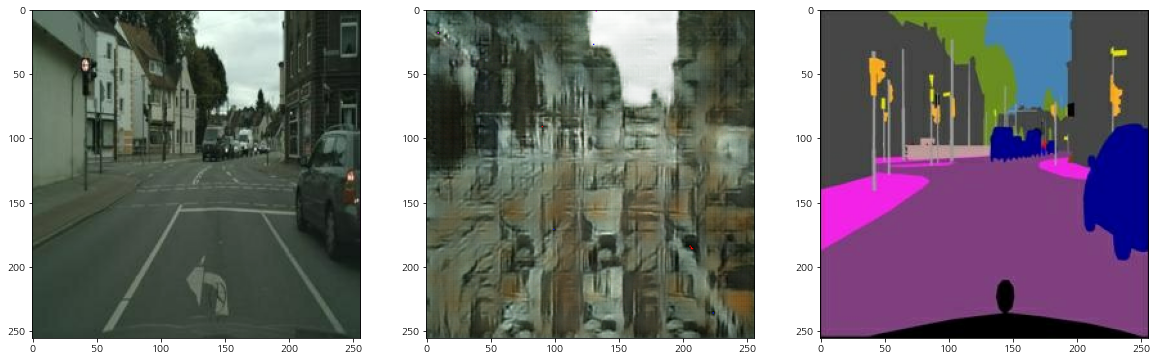

In [26]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))


## 에포크 200번 돌렸을때

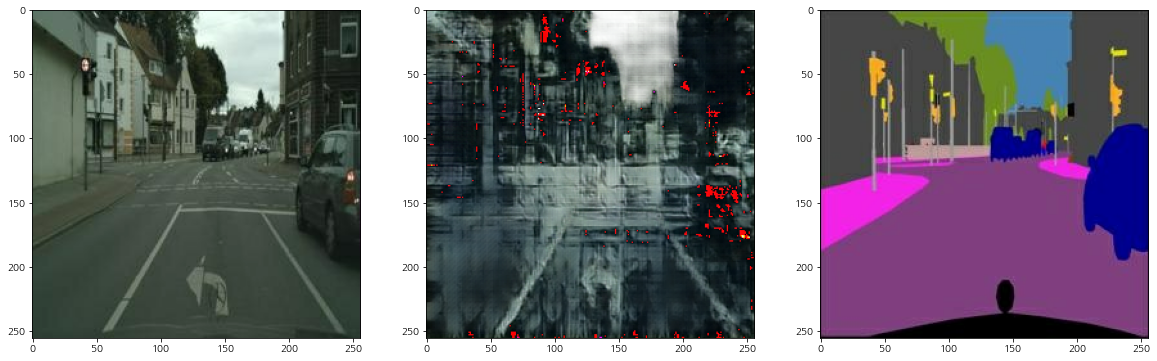

In [26]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))


## 에포크 300번 돌렸을때

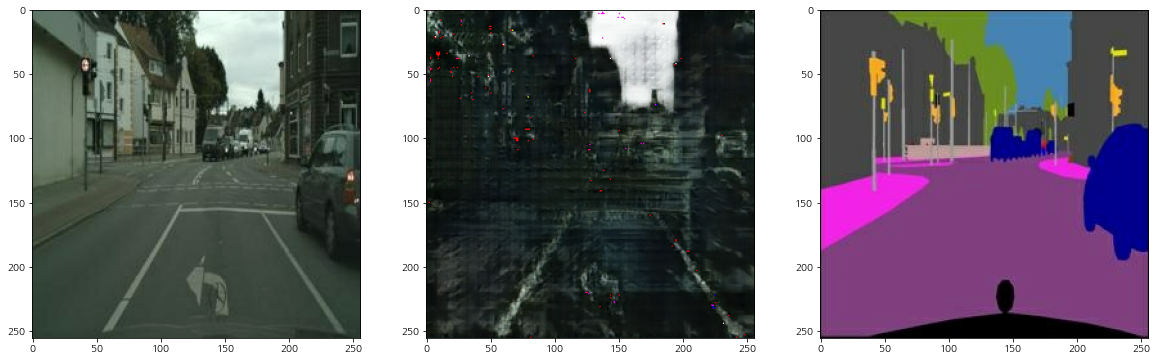

In [55]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))


에포크 100, 200, 300 으로 모델을 돌려봤다. 결과는 위과 같이 나온다.  에포크 100일때와 300일때의 히스토리 값을 결과값을 실수로 지워버려서 확인을 못하고 200일때만 확인할수 있다.

# 궁금한것들

#### 서브 클래싱
-구현 되어 있는 클래스를 상속하는것

#### 컨볼루션 신경망 레이어()
- [사이트주소](https://tykimos.github.io/2017/01/27/CNN_Layer_Talk/)

1. 플래튼(Flatten) 레이어
   -  영상을 일차원으로 바꿔주눈 플래튼(Flatten) 레이어
   - CNN에서 컨볼루션 레이어나 맥스풀링 레이어를 반복적으로 거치면 주요 특징만 추출되고, 추출된 주요 특징은 전결합층에 전달되어 학습됩니다. 컨볼루션 레이어나 맥스풀링 레이어는 주로 2차원 자료를 다루지만 전결합층에 전달하기 위해선 1차원 자료로 바꿔줘야 합니다. 이 때 사용되는 것이 플래튼 레이어입니다. 사용 예시는 다음과 같습니다.
   

2. Maxout 레이어
  - 두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 가져오도록 합니다.  

#### Pix2Pix
- 이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델입니다